In [527]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.cross_validation import train_test_split
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import linear_model, cross_validation
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, Lasso, Ridge, ElasticNet
from sklearn import pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR

from xgboost import XGBClassifier as xgb
from xgboost import XGBRegressor as xgbr
import string
from sklearn.pipeline import TransformerMixin, FeatureUnion, make_pipeline, make_union
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline

from nltk.tokenize import word_tokenize #, PunktSentenceTokenizer, 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, matutils
import time, random, json, math, sys

In [2]:
t00 = time.time()

In [477]:
def getpercentile(mylist, myval):
    s = sorted(mylist)
    s2 = sorted(mylist)
    n = (s.index(myval) + 1)/len(mylist)*100
    n2 = (s2.index(myval) + 2)/len(mylist)*100
    return n, n2

def percentile(mylist, mypercentile):
    s = sorted(mylist)
    n = (mypercentile/100 * len(mylist)) - 0.5
    if n == int(n):
        return s[int(n)]
    else:
        return (s[int(n) + 1] - s[int(n)]) * (n - int(n)) + s[int(n)]

def ptransform(myseries, mypercentile):
    thresh = percentile(myseries.values.tolist(), mypercentile)
    return (myseries > thresh) + 0

def scoreapprox(targets):
    return targets['*'] + 2 * targets['**'] + 3 * targets['***']

In [4]:
def year(string):
    ymd = string.split('-')
    return int(ymd[0])

def month(string):
    ymd = string.split('-')
    return int(ymd[1])

def day(string):
    ymd = string.split('-')
    return int(ymd[2])

def decyear(string):
    ymd = string.split('-')
    return int(ymd[0]) + (int(ymd[1]) - 1)/12 + (int(ymd[2]) - 1)/(31*12)

def dateparse(dataframe, datecol):
    dataframe['year'] =  dataframe.date.apply(year,0)
    dataframe['month'] =  dataframe.date.apply(month,0)
    dataframe['day'] =  dataframe.date.apply(day,0)
    dataframe['decyear'] = dataframe.date.apply(decyear,0)

In [5]:
ids = pd.read_csv('restaurant_ids_to_yelp_ids.csv')
yelpcols = ['yelp_id_0', 'yelp_id_1', 'yelp_id_2', 'yelp_id_3']
bostids = ids['restaurant_id'].values.tolist()
yelpids = ids[yelpcols].values.tolist()

In [6]:
id_dict = {}
for i in range(len(yelpids)):
    line = yelpids[i]
    for yelpid in line:
        if type(yelpid) == str:
            if len(yelpid) > 5:
                id_dict[yelpid] = bostids[i]

In [7]:
idvals = list(id_dict.values())
idvalcts, ones = [], []
goodvals = []
for idval in idvals:
    ct = idvals.count(idval)
    idvalcts.append(ct) 
    ones.append((ct == 1) + 0)
sum(ones)/len(ones)

0.9555206698063841

In [8]:
valsdict = {}

violations = pd.read_csv('AllViolations.csv')
dateparse(violations, 'date')

vlist = violations[['date','decyear','*','**','***','restaurant_id']].values.tolist()
for line in vlist:
    entry = line[:-1]
    rid = line[-1]
    if rid not in valsdict.keys():
        valsdict[rid] = [entry]
    else:
        valsdict[rid].append(entry)

for key in valsdict.keys():
    valsdict[key].sort()

In [9]:
crimedata = pd.read_csv('Crime_Incident_Reports__July_2012_-_August_2015___Source__Legacy_System_.csv')
crimedata.head()

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,COMPNOS,NatureCode,INCIDENT_TYPE_DESCRIPTION,MAIN_CRIMECODE,REPTDISTRICT,REPORTINGAREA,FROMDATE,WEAPONTYPE,Shooting,DOMESTIC,SHIFT,Year,Month,DAY_WEEK,UCRPART,X,Y,STREETNAME,XSTREETNAME,Location
0,120420285.0,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,763273.1791,2951498.962,ABERDEEN ST,NaN,"(42.34638135, -71.10379454)"
1,120419202.0,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,2012,7,Sunday,Part One,771223.1638,2940772.099,HOWARD AV,NaN,"(42.31684135, -71.07458456)"
2,120419213.0,ARMROB,ROBBERY,03xx,D4,625,07/08/2012 06:26:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,765118.8605,2950217.536,JERSEY ST,QUEENSBERRY ST,"(42.34284135, -71.09698955)"
3,120419223.0,ALARMC,COMMERCIAL BURGLARY,05CB,B2,258,07/08/2012 06:56:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,773591.8648,2940638.174,COLUMBIA RD,NaN,"(42.3164411, -71.06582908)"
4,120419236.0,ARMROB,ROBBERY,03xx,E18,496,07/08/2012 07:15:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,759042.7315,2923832.681,COLLINS ST,NaN,"(42.27051636, -71.11989955)"


In [10]:
crimelocs = crimedata.Location.values.tolist()
crimelats, crimelongs = [], []
for line in crimelocs:
    crimelats.append(line[0])

In [11]:
def getlatlong(mystring, which):
    mylist = mystring.replace('(','').replace(')','').split(', ')
    lat, long = float(mylist[0]), float(mylist[1])
    out = [np.nan, [lat,long][which]]
    check = (lat > 40) * (lat < 45) * (long < -70) * (long > -75)
    return out[check]
def getlats(mystring):
    return getlatlong(mystring,0)
def getlongs(mystring):
    return getlatlong(mystring,1)
crimedata['lat'] = crimedata.Location.apply(getlats,0)
crimedata['long'] = crimedata.Location.apply(getlongs,0)
cll = crimedata[['lat','long']]
cll.dropna(inplace = True)
cll.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,lat,long
0,42.3464,-71.1038
1,42.3168,-71.0746
2,42.3428,-71.097
3,42.3164,-71.0658
4,42.2705,-71.1199


ALL RESTAURANT IDS ARE INCLUDED

In [12]:
with open('yelp_academic_dataset_review.json') as f:
    reviews = f.readlines()

with open('yelp_academic_dataset_user.json') as f:
    users = f.readlines()
    
with open('yelp_academic_dataset_tip.json') as f:
    tips = f.readlines()

with open('yelp_academic_dataset_business.json') as f:
    businesses = f.readlines()

In [13]:
def jsonstolist(lines):
    dicts, allkeys = [], []
    for line in lines:
        d = json.loads(line)
        d2 = {}
        for key in list(d.keys()):
            if type(d[key]) != dict:
                d2[key] = d[key]
            else:
                for key2 in list(d[key].keys()):
                    d2[key2] = d[key][key2]
        dicts.append(d2)
        allkeys.extend(list(d2.keys()))
    unique_keys = list(set(allkeys))
    biglist = []
    for d in dicts:
        linelist = []
        for category in unique_keys:
            if category in d.keys():
                linelist.append(d[category])
            else:
                linelist.append(0)
        biglist.append(linelist)
    return biglist, unique_keys

In [14]:
businesses_list, businessess_columns = jsonstolist(businesses)
bdata = pd.DataFrame(businesses_list, columns = businessess_columns)

In [15]:
reviews_list, reviews_columns = jsonstolist(reviews)
rdata = pd.DataFrame(reviews_list, columns = reviews_columns)

In [16]:
dateparse(rdata,'date')

In [17]:
tips_list, tips_columns = jsonstolist(tips)
tdata = pd.DataFrame(tips_list, columns = tips_columns)

In [18]:
dateparse(tdata,'date')

In [19]:
users_list, users_columns = jsonstolist(users)
udata = pd.DataFrame(users_list, columns = users_columns)

In [20]:
bdata.columns

Index(['full_address', 'Noise Level', 'Caters', 'review_count', 'city',
       'Payment Types', 'Outdoor Seating', 'Parking', 'Wi-Fi', 'Has TV',
       'Thursday', 'Dietary Restrictions', 'Alcohol', 'Good for Kids',
       'Monday', 'Delivery', 'Friday', 'Dogs Allowed', 'Open 24 Hours',
       'Coat Check', 'BYOB', 'Music', 'Ages Allowed', 'Tuesday', 'Sunday',
       'Wednesday', 'Attire', 'Accepts Credit Cards', 'categories', 'stars',
       'Good For', 'Takes Reservations', 'latitude', 'type', 'Drive-Thru',
       'Wheelchair Accessible', 'state', 'Saturday', 'Smoking',
       'Good For Dancing', 'Good For Kids', 'Happy Hour', 'Corkage',
       'business_id', 'By Appointment Only', 'neighborhoods', 'BYOB/Corkage',
       'name', 'Price Range', 'open', 'Take-out', 'Waiter Service',
       'Order at Counter', 'Ambience', 'longitude', 'Good For Groups'],
      dtype='object')

In [21]:
bdata['Good For Kids'] = bdata['Good For Kids'] + bdata['Good for Kids']
bdata.drop('Good for Kids', axis=1, inplace=True)
bdata.columns

Index(['full_address', 'Noise Level', 'Caters', 'review_count', 'city',
       'Payment Types', 'Outdoor Seating', 'Parking', 'Wi-Fi', 'Has TV',
       'Thursday', 'Dietary Restrictions', 'Alcohol', 'Monday', 'Delivery',
       'Friday', 'Dogs Allowed', 'Open 24 Hours', 'Coat Check', 'BYOB',
       'Music', 'Ages Allowed', 'Tuesday', 'Sunday', 'Wednesday', 'Attire',
       'Accepts Credit Cards', 'categories', 'stars', 'Good For',
       'Takes Reservations', 'latitude', 'type', 'Drive-Thru',
       'Wheelchair Accessible', 'state', 'Saturday', 'Smoking',
       'Good For Dancing', 'Good For Kids', 'Happy Hour', 'Corkage',
       'business_id', 'By Appointment Only', 'neighborhoods', 'BYOB/Corkage',
       'name', 'Price Range', 'open', 'Take-out', 'Waiter Service',
       'Order at Counter', 'Ambience', 'longitude', 'Good For Groups'],
      dtype='object')

In [22]:
numcols, dictcols, seminumcols, othercols = [], [], [], []
for colname in list(bdata.columns):
    try:
        sum(bdata[colname])
        numcols.append(colname)
    except TypeError:
        head = bdata[colname].tolist()
        dl = 0
        n = 0
        for entry in head:
            dl = dl + (type(entry) in [dict, list])
            n = n + (type(entry) in [int, float, bool])
        if dl > 1:
            dictcols.append(colname)
        elif n > len(bdata)/4:
            seminumcols.append(colname)
        else:
            othercols.append(colname)
print(numcols)
print(dictcols)
print(seminumcols)
print(othercols)

['Caters', 'review_count', 'Outdoor Seating', 'Has TV', 'Delivery', 'Dogs Allowed', 'Open 24 Hours', 'Coat Check', 'BYOB', 'stars', 'Takes Reservations', 'latitude', 'Drive-Thru', 'Wheelchair Accessible', 'Good For Dancing', 'Good For Kids', 'Happy Hour', 'Corkage', 'By Appointment Only', 'Price Range', 'open', 'Take-out', 'Waiter Service', 'Order at Counter', 'longitude', 'Good For Groups']
['Payment Types', 'Parking', 'Thursday', 'Dietary Restrictions', 'Monday', 'Friday', 'Music', 'Tuesday', 'Sunday', 'Wednesday', 'Accepts Credit Cards', 'categories', 'Good For', 'Saturday', 'neighborhoods', 'Ambience']
['Noise Level', 'Wi-Fi', 'Ages Allowed', 'Smoking', 'BYOB/Corkage']
['full_address', 'city', 'Alcohol', 'Attire', 'type', 'state', 'business_id', 'name']


In [23]:
bdata[dictcols].head()

,Payment Types,Parking,Thursday,Dietary Restrictions,Monday,Friday,Music,Tuesday,Sunday,Wednesday,Accepts Credit Cards,categories,Good For,Saturday,neighborhoods,Ambience
0,0,"{'garage': False, 'validated': False, 'valet':...",0,0,0,0,0,0,0,0,True,"[Bakeries, Food, Event Planning & Services, Ca...",0,0,[Financial District],0
1,0,"{'garage': False, 'validated': False, 'valet':...","{'close': '15:00', 'open': '06:00'}",0,"{'close': '15:00', 'open': '06:00'}","{'close': '15:00', 'open': '06:00'}",0,"{'close': '15:00', 'open': '06:00'}",0,"{'close': '15:00', 'open': '06:00'}",0,"[Delis, Restaurants, Event Planning & Services...","{'latenight': False, 'breakfast': False, 'dess...",0,[Beacon Hill],"{'hipster': False, 'upscale': False, 'touristy..."
2,0,"{'garage': False, 'validated': False, 'valet':...","{'close': '16:00', 'open': '05:30'}",0,"{'close': '16:00', 'open': '05:30'}","{'close': '16:00', 'open': '05:30'}",0,"{'close': '16:00', 'open': '05:30'}",0,"{'close': '16:00', 'open': '05:30'}",True,"[Delis, Restaurants]","{'latenight': False, 'breakfast': False, 'dess...",0,[Downtown],"{'hipster': False, 'upscale': False, 'touristy..."
3,0,"{'garage': False, 'validated': False, 'valet':...","{'close': '18:00', 'open': '05:00'}",0,"{'close': '18:00', 'open': '05:00'}","{'close': '18:00', 'open': '05:00'}",0,"{'close': '18:00', 'open': '05:00'}",0,"{'close': '18:00', 'open': '05:00'}",True,"[Food, Sandwiches, Coffee & Tea, Breakfast & B...","{'latenight': False, 'breakfast': True, 'desse...","{'close': '13:00', 'open': '07:00'}","[Beacon Hill, Downtown]","{'hipster': False, 'upscale': False, 'touristy..."
4,0,"{'garage': True, 'validated': False, 'valet': ...","{'close': '22:00', 'open': '06:30'}",0,"{'close': '22:00', 'open': '06:30'}","{'close': '22:00', 'open': '06:30'}",0,"{'close': '22:00', 'open': '06:30'}","{'close': '22:00', 'open': '07:00'}","{'close': '22:00', 'open': '06:30'}",True,"[American (New), Restaurants]","{'latenight': False, 'breakfast': False, 'dess...","{'close': '22:00', 'open': '07:00'}",[Downtown],"{'hipster': False, 'upscale': False, 'touristy..."


Parse all of em

In [24]:
def dictbinaries(dataframe, colname):
    allkeys = []
    mylist = dataframe[colname].values.tolist()
    for line in mylist:
        if type(line) == dict:
            allkeys.extend(list(line.keys()))
        elif type(line) == list:
            allkeys.extend(line)
    allkeys = list(set(allkeys))
    newnames = []
    for key in allkeys:
        newname = colname + '_' + key
        def addbinary(mydict):
            out = 0
            if type(mydict) == dict:
                if key in mydict.keys():
                    out = mydict[key]
            elif type(mydict) == list:
                out = (key in mydict)
            if type(out) == str:
                if ':' in out[2:]:
                    cp = out.find(':')
                    hour = int(out[cp-2:cp])
                    minute = int(out[cp+1:cp+3])
                    out = hour + minute/60
            return out
        dataframe[newname] = dataframe[colname].apply(addbinary,1)
        newnames.append(newname)
    return newnames

In [25]:
def quintiles(mylist, n = 5):
    slist = sorted(mylist)
    out = []
    for i in range(n):
        start = int(i*len(slist)/n)
        end = int((i+1)*len(slist)/n)
        if end >= len(slist):
            end = len(slist) - 1
        out.append([slist[start], slist[end]])
#         out.append(slist[i * interval - 1])
    return out    

def quintilize(dataframe, colname, n = 5, mode = 'both'):
    quints = quintiles(dataframe[colname].values.tolist(), n = n)
    newnames = []
    bigname = colname + '_quintile'
    if mode in ['single','both']:
        newnames.append(bigname)
    for i in range(len(quints)):
        [start, end] = quints[i]
        end = end + (i == len(quints) - 1) # increase if at end to be inclusive
        def inrange(val):
            return (val >= start)*(val < end) + 0
        if mode in ['binaries','both']:
            newname = colname + '_quintile_' + str(i + 1)
            newnames.append(newname)
            dataframe[newname] = dataframe[colname].apply(inrange,1)
        if mode in ['single','both']:
            if i == 0:
                dataframe[bigname] = dataframe[colname].apply(inrange,1) * (i + 1)
            else:
                dataframe[bigname] = dataframe[bigname] + dataframe[colname].apply(inrange,1) * (i + 1)
    return newnames

In [26]:
dictnumcols = dictbinaries(bdata,dictcols[0])
for col in dictcols[1:]:
    dictnumcols.extend(dictbinaries(bdata, col))

Double check types

In [27]:
for col in dictnumcols:
    try:
        sum(bdata[col])
    except TypeError:
        print(col)

All numerical, now checking semi-numerical

In [28]:
bdata[seminumcols].head()

,Noise Level,Wi-Fi,Ages Allowed,Smoking,BYOB/Corkage
0,0,0,0,0,0
1,average,no,0,0,0
2,average,0,0,0,0
3,average,free,0,0,0
4,quiet,no,0,0,0


In [29]:
for col in seminumcols:
    print(col)
    print(bdata[col].value_counts())
    print()

Noise Level
average      921
0            533
quiet        219
loud         172
very_loud     85
Name: Noise Level, dtype: int64

Wi-Fi
no      885
0       637
free    392
paid     16
Name: Wi-Fi, dtype: int64

Ages Allowed
0          1912
21plus       17
allages       1
Name: Ages Allowed, dtype: int64

Smoking
0          1560
no          308
outdoor      55
yes           7
Name: Smoking, dtype: int64

BYOB/Corkage
0              1274
no              433
yes_free        187
yes_corkage      36
Name: BYOB/Corkage, dtype: int64



In [30]:
bdata['Smokingb'] = (bdata.Smoking == 'yes') + (bdata.Smoking == 'outdoor') + 0
bdata['wifib'] = (bdata['Wi-Fi'] == 'free') + (bdata['Wi-Fi'] == 'paid') + 0
bdata['Corkage'] = ((bdata['Corkage'] + (bdata['BYOB/Corkage'] == 'yes_corkage'))>0) + 0
bdata['allages'] = (bdata['Ages Allowed'] != 0) + 0
bdata['BYOB'] = (((bdata['BYOB/Corkage'] == 'yes_free') + 0 + bdata['BYOB']) > 0) + 1
bdata['Noise'] = (bdata['Noise Level'] == 'average') + 2*(bdata['Noise Level'] == 'loud') + 3*(bdata['Noise Level'] == 'very_loud')
noisemean = bdata['Noise'][bdata['Noise Level'] != 0].mean()
bdata['Noise'] = bdata['Noise'] + noisemean * (bdata['Noise Level'] == 0)
snumcols = ['Noise','Smokingb', 'wifib', 'allages']

//anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


Now the others

In [31]:
bdata[othercols].head()

,full_address,city,Alcohol,Attire,type,state,business_id,name
0,"75 Federal Street\nFinancial District\nBoston,...",Boston,0,0,business,MA,Jp9svt7sRT4zwdbzQ8KQmw,Rebecca's Cafe
1,"8 City Hall Ave\nBeacon Hill\nBoston, MA 02108",Boston,0,casual,business,MA,CgdK8DiyX9Y4kTKEPi_qgA,Delicato Cafe & Caterer
2,"2 Center Plz\nDowntown\nBoston, MA 02108",Boston,none,casual,business,MA,SAnMTC1rm-PhP8DQC4zeyg,Plaza Deli
3,"122 Bowdoin St\nBeacon Hill\nBoston, MA 02108",Boston,none,casual,business,MA,75dtVyDb8Sfwb7dR0cBvdg,Capitol Coffee House
4,"60 School St\nDowntown\nBoston, MA 02108",Boston,full_bar,dressy,business,MA,0uvgsJnwyCvNpjHOEYtlyQ,Parker's Restaurant


In [32]:
for col in othercols:
    print(col)
    print(bdata[col].value_counts())
    print()

full_address
800 Boylston St\nBack Bay\nBoston, MA 02199                                                       8
417 Washington St\nDowntown\nBoston, MA 02108                                                     6
334 Massachusetts Ave\nBoston, MA 02115                                                           4
1095 Commonwealth Ave\nAllston/Brighton\nBoston, MA 02215                                         4
1 Faneuil Hall Market Pl\nBoston, MA 02109                                                        4
184 High St\nFinancial District\nBoston, MA 02110                                                 4
350 Longwood Ave\nBoston, MA 02115                                                                3
15 Arlington St\nBack Bay\nBoston, MA 02116                                                       3
1395 Washington St\nSouth End\nBoston, MA 02118                                                   3
255 State St\nWaterfront\nBoston, MA 02109                                             

In [33]:
bdata['fancy'] = (bdata.Attire == 'dressy') + (bdata.Attire == 'formal')
bdata['alc'] = (bdata.Alcohol == 'full_bar') * 2 + (bdata.Alcohol == 'beer_and_wine') * 1
alcmean = bdata['alc'][bdata['Alcohol'] != 0].mean()
bdata['alc'] = bdata['alc']  + alcmean * (bdata['Alcohol'] == 0)
onumcols = ['fancy','alc']
cities = list(set(bdata.city.values.tolist()))
for city in cities:
    name = 'city_' + city
    onumcols.append(name)
    bdata[name] = bdata.city == city

//anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [34]:
all_numerical_columns = numcols[:]
all_numerical_columns.extend(dictnumcols)
all_numerical_columns.extend(snumcols)
all_numerical_columns.extend(onumcols)

(0, 100)

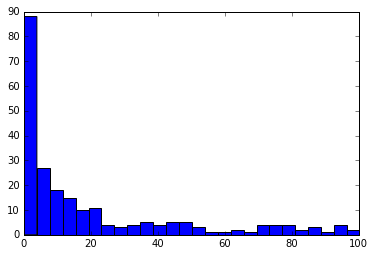

In [35]:
nonzeros = []
good_numerical_columns = []
for colname in all_numerical_columns:
    nonzero = sum((bdata[colname] != 0))
    nonzeros.append(nonzero)
    if nonzero > 30:
        good_numerical_columns.append(colname)
plt.hist(nonzeros, bins = 500)
plt.xlim([0,100])

Most of these aren't too common; so I set a minimum of 50 establishments to prevent overfitting.

In [36]:
len(good_numerical_columns) == len(set(good_numerical_columns))

True

No dupes! Now bool to numerical:

In [37]:
for name in good_numerical_columns:
    bdata[name] = bdata[name] + 0
bdata[good_numerical_columns].head()

,Caters,review_count,Outdoor Seating,Has TV,Delivery,Coat Check,BYOB,stars,Takes Reservations,latitude,...,wifib,fancy,alc,city_Roslindale,city_Allston,city_Jamaica Plain,city_Brighton,city_Dorchester,city_Boston,city_West Roxbury
0,0,6,0,0,0,0,1,3.5,0,42.355083,...,0,0,0.923313,0,0,0,0,0,1,0
1,1,44,0,0,0,0,1,4.0,0,42.357500,...,0,0,0.923313,0,0,0,0,0,1,0
2,1,12,0,0,1,0,1,3.0,0,42.360074,...,0,0,0.000000,0,0,0,0,0,1,0
3,1,60,0,0,0,0,1,3.5,0,42.358870,...,1,0,0.000000,0,0,0,0,0,1,0
4,0,111,0,0,0,0,1,3.5,1,42.357845,...,0,1,2.000000,0,0,0,0,0,1,0


In [38]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
            
def time_open(dataframe, mydays, prefix):
    cols_summed = []
    newname = prefix + '_time_open'
    for i in range(len(mydays)):
        day = mydays[i]
        topen, tclose = day+ '_open', day+ '_close'
        if (topen in dataframe.columns)*(tclose in dataframe.columns) == 1:
            diff = dataframe[tclose] - dataframe[topen]
            diff2 = diff + (diff < 0)*24
            if i > 0:
                dataframe[newname] = dataframe[newname] + diff2
            else:
                dataframe[newname] = diff2
            cols_summed.extend([topen,tclose])
    return cols_summed, newname

weekdaycols, weekdaycol = time_open(bdata, weekdays, 'weekday')
weekendcols, weekendcol = time_open(bdata, weekends, 'weekend')

good_numerical_columns.extend([weekdaycol,weekendcol])
todrop = weekdaycols[:]
todrop.extend(weekendcols)
for line in todrop:
    while line in good_numerical_columns:
        good_numerical_columns.remove(line)

In [39]:
bdata[good_numerical_columns].head()

,Caters,review_count,Outdoor Seating,Has TV,Delivery,Coat Check,BYOB,stars,Takes Reservations,latitude,...,alc,city_Roslindale,city_Allston,city_Jamaica Plain,city_Brighton,city_Dorchester,city_Boston,city_West Roxbury,weekday_time_open,weekend_time_open
0,0,6,0,0,0,0,1,3.5,0,42.355083,...,0.923313,0,0,0,0,0,1,0,0.0,0.0
1,1,44,0,0,0,0,1,4.0,0,42.357500,...,0.923313,0,0,0,0,0,1,0,45.0,0.0
2,1,12,0,0,1,0,1,3.0,0,42.360074,...,0.000000,0,0,0,0,0,1,0,52.5,0.0
3,1,60,0,0,0,0,1,3.5,0,42.358870,...,0.000000,0,0,0,0,0,1,0,65.0,6.0
4,0,111,0,0,0,0,1,3.5,1,42.357845,...,2.000000,0,0,0,0,0,1,0,77.5,30.0


In [40]:
for name in ['lat','long','latitude','longitude']:
    while name in good_numerical_columns:
        good_numerical_columns.remove(name)
        
toget = ['business_id']
toget.extend(good_numerical_columns)

junk = []

othervalsdict = {}
biglist = bdata[toget].values.tolist()
for line in biglist:
    othervalsdict[line[0]] = line[1:]
    junk.append(line[1:])

In [41]:
boston_centroid = [(cll.lat.mean() + bdata.latitude.mean())/2,(cll.long.mean() + bdata.longitude.mean())/2]
# arithmetic mean of lats and longs of criminal activity and restaurants
# at this latitude, 111 km per degree lat, 82 km per degree long for small delta
# approximation for quick computation
# converting lat longs to centroid here


def boston_xy(dataframe):
    if 'lat' in dataframe.columns:
        lat, long = 'lat', 'long'
    elif 'latitude' in dataframe.columns:
        lat, long = 'latitude', 'longitude'
    dataframe['y'] = (dataframe[lat] - boston_centroid[0])*111
    dataframe['x'] = (dataframe[long] - boston_centroid[1])*82
# cll['y'] = (cll.lats - boston_centroid[0])*111
# cll['x'] = (cll.longs - boston_centroid[1])*82
boston_xy(cll)
boston_xy(bdata)
cxy = cll[['x','y']]


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
cxy_sub = cxy.sample(n = 1000)# for speed
def get_close_boston(myx, myy, thresh, data, ltype = 'euclidean'):
    if ltype == 'euclidean':
        dists = np.square(myy - data.y) + np.square(myx - data.x)
    if ltype == 'manhattan':
        dists = myy - data.y + myx - data.x
    return sum(dists < thresh)/len(data)

bizlatlong = bdata[['business_id','x','y']]
bizxy = bizlatlong.values.tolist()
nearstuff = {}
t0 = time.time()
for line in bizxy:
    nearstuff[line[0]] = [line[1], line[2], get_close_boston(line[1], line[2], 2, cxy_sub),
                          get_close_boston(line[1], line[2], 1, cxy_sub),
                          get_close_boston(line[1], line[2], 0.5, cxy_sub),
                          get_close_boston(line[1], line[2], 0.25, cxy_sub),
                          get_close_boston(line[1], line[2], 0.1, cxy_sub),
                          get_close_boston(line[1], line[2], 2, bizlatlong), 
                          get_close_boston(line[1], line[2], 1, bizlatlong),
                          get_close_boston(line[1], line[2], .5, bizlatlong), 
                          get_close_boston(line[1], line[2], .25, bizlatlong), 
                          get_close_boston(line[1], line[2], .1, bizlatlong)]
print(time.time()-t0)

61.548299074172974


In [43]:
biznames = bdata[['name','business_id']].values.tolist()
namewords = []
for i in range(len(biznames)):
    linewords = biznames[i][0].split()
    namewords.extend(linewords)
    biznames[i].append(linewords)
# biznames[0]#.lower()
namewords = list(set(namewords))
freqdict = {}
for word in namewords:
    counter = 0
    for line in biznames:
        counter = counter + (word in line[2])
    freqdict[word] = counter
        

In [44]:
recurring = []
for key in freqdict.keys():
    if freqdict[key] > 1:
        recurring.append(key)
len(recurring)/len(freqdict.keys())

0.2879396984924623

71% of words that occur in restaurant names only do so once

In [45]:
killdict = {}
for line in biznames:
    tokill = []
    for word in line[2]:
        if word not in recurring:
            tokill.append(word)
    killdict[line[1]] = tokill

In [46]:
rbiz = set(rdata.business_id.unique())
tbiz = set(tdata.business_id.unique())
biz = rbiz.intersection(tbiz)
biz = list(biz.intersection(set(id_dict.keys())))
len(biz)

1584

In [47]:
name_ids = {}
for line in biznames:
    name_ids[line[1]] = line[0]
    if line[1] in id_dict.keys():
        name_ids[id_dict[line[1]]] = line[0]

In [48]:
def restname(restid):
    return name_ids[restid]

dateparse(violations, 'date')
    
violations['name'] = violations.restaurant_id.apply(restname,0)
violations_recent = violations[violations.year > 2014]
violations_recent = violations_recent[violations_recent.month > 5]


Matched these to actual; found the meaning of each category:
one asterisk = non critical violation
two = critical violation
three = critical violation with foodborne illness

In [49]:
sum(violations['*'] > 0)/len(violations)

0.78864072937870922

In [50]:
def splitfilter(textlist,badwords):
    badwords_lower = []
    for badword in badwords:
        badwords_lower.append(badword.lower())
    goodtextlist = []    
    for line in textlist:
#         print(line)
        words = line[0][0].split()
        goodtext = ''
#         print(words)
        for word in words:
            if word.lower() not in badwords_lower:
                goodtext = goodtext + word + ' '
        goodtextlist.append(goodtext)
    return goodtextlist
                
            
        

In [51]:
def filtered_text(row):
    badwords_lower = []
    for word in killdict[row['business_id']]:
        badwords_lower.append(word)
    words = row['text'].split()
    outtext = ''
    for word in words:
        if word.lower() not in badwords_lower:
            outtext = outtext + word + ' '
    return outtext

rdata['filtered_text'] = rdata.apply(filtered_text, axis = 1)
tdata['filtered_text'] = rdata.apply(filtered_text, axis = 1)

In [52]:
def dupeu(row):
    return ((row['filtered_text'] + '\n') * (row['useful'] + 1))[:-1]
def dupel(row):
    return ((row['filtered_text'] + '\n') * (row['likes'] + 1))[:-1]
rdata['filtered_text_dupe'] = rdata.apply(dupeu, axis = 1)
tdata['filtered_text_dupe'] = tdata.apply(dupel, axis = 1)


In [53]:
allr = '\n'.join(rdata.filtered_text.values.tolist())[:-1]
allr2 = '\n'.join(rdata.filtered_text_dupe.values.tolist())[:-1]
print('reviews: ' + str(len(allr2)/len(allr)))

allt = '\n'.join(tdata.filtered_text.values.tolist())[:-1]
allt2 = '\n'.join(tdata.filtered_text_dupe.values.tolist())[:-1]
print('tips: ' + str(len(allt2)/len(allt)))

reviews: 2.0172876154804165
tips: 1.0054608693539175


doubles the list length for reviews, slight increase for tips

In [54]:
def skipjoin(mylist,splitstr):
    out = ''
    for entry in mylist:
        if type(entry) == str:
            out = out + entry + splitstr
        elif type(entry) == list:
            if len(entry) > 0:
                if type(entry[0]) == str:
                    out = out + entry[0] + splitstr
    return out

In [55]:
def monthguess(decdate):
    return int((decdate - int(decdate))*12) + 1
# ascending temperature order
# fall above spring reflecting that average of spring --> fall greater than fall -->spring
def getseason(monthint):
    if monthint in [12,1,2]:
        return 0
    elif monthint in [3,4,5]:
        return 1
    elif monthint in [6,7,8]:
        return 3
    elif monthint in [9,10,11]:
        return 2

In [56]:
def getcol(mylol,colnum):
    out = []
    for line in mylol:
        if type(line) == list:
            if len(line) > 1:
                if type(line[colnum]) in [float, int]:
                    out.append(line[colnum])
    return out

def ratingstuff(starvals):
    L = len(starvals)
    ratingpcts = []
    for starval in uniquestars:
        ratingpcts.append(starvals.count(starval)/L)
    ratingpcts.append(sum(starvals)/L)
    return ratingpcts

In [57]:
uniquestars = sorted(list(rdata.stars.unique()))
uniquestars

[1, 2, 3, 4, 5]

In [58]:
singledoc, multidoc, targetvals = [], [], []

t0 = time.time()

windows, befores, allbefores, alldocs = [], [], [], []
total_inspections = 0
rblens, rwlens = [],[]
for entry in biz:
    rb = rdata[rdata.business_id == entry]
    tb = tdata[tdata.business_id == entry]
    targs = valsdict[id_dict[entry]]
    xycrimebiz = nearstuff[entry]
    pairs = []
    badwords_lower = []
    othervalstuff = othervalsdict[entry]
    atext = rb[['filtered_text_dupe','decyear','stars']].values.tolist()
    aratingpcts = ratingstuff(getcol(atext,2))
    atext.append(tb[['filtered_text_dupe','decyear']].values.tolist())
    random.shuffle(atext)
    outa = [skipjoin(atext,'\n\n\n')]
    outa.append(entry)
    outa.extend(xycrimebiz)
    outa.extend(othervalstuff)
    outa.extend(aratingpcts)
    outa.extend([len(rb), len(tb)])
    alldocs.append(outa)
#     outa.extend(targs[i][2:])
    for word in killdict[entry]:
        badwords_lower.append(word.lower())
    for i in range(len(targs)):
        total_inspections = total_inspections + 1
        end = targs[i][1]
        startb = end - 0.3333# found median about .31, mean about .36; 4 months is convenient
        startw = startb

        if i > 0:
            startw = max([startb, targs[i-1][1]])
        rbe = rb[rb.decyear < end]
        tbe = tb[tb.decyear < end]
        rbw = rbe[rbe.decyear > startw]
        tbw = tbe[tbe.decyear > startw]
        rbb = rbe[rbe.decyear > startb]
        tbb = tbe[tbe.decyear > startb]
        season_end = getseason(monthguess(end))
#         season_avgw = season_end + getseason(monthguess(startw))/2
        if len(rbw) > 0:
            if len(rbb) > 0:
                abtext = rbe[['filtered_text_dupe','decyear','stars']].values.tolist()
                abratingpcts = ratingstuff(getcol(abtext,2))
                abtext.append(tbe[['filtered_text_dupe','decyear']].values.tolist())
                abtimerange = end - min(getcol(abtext,1))
                abtimemean = end - sum(getcol(abtext,1))/len(getcol(abtext,1))
                btext = rbb[['filtered_text_dupe','decyear','stars']].values.tolist()
                bratingpcts = ratingstuff(getcol(btext,2))
                btext.append(tbb[['filtered_text_dupe','decyear']].values.tolist())
                btimerange = end - min(getcol(btext,1))
                btimemean = end - sum(getcol(btext,1))/len(getcol(btext,1))
                wtext = rbw[['filtered_text_dupe','decyear','stars']].values.tolist()
                wratingpcts = ratingstuff(getcol(wtext,2))
                wtext.append(tbw[['filtered_text_dupe','decyear']].values.tolist())
                wtimerange = end - min(getcol(wtext,1))
                wtimemean = end - sum(getcol(wtext,1))/len(getcol(wtext,1))
                random.shuffle(abtext)
                random.shuffle(btext)
                random.shuffle(wtext)
                
                outb = [skipjoin(btext,'\n\n\n')]
                outb.append(entry)
                outb.extend(xycrimebiz)
                outb.append(season_end)
                outb.extend(othervalstuff)
                outb.extend(bratingpcts)
                outb.extend([len(rbb), len(tbb), btimerange, btimemean])
                outb.extend(targs[i][2:])
                befores.append(outb)
                
                outab = [skipjoin(abtext,'\n\n\n')]
                outab.append(entry)
                outab.extend(xycrimebiz)
                outab.append(season_end)
                outab.extend(othervalstuff)
                outab.extend(abratingpcts)
                outab.extend([len(rbe), len(tbe), abtimerange, abtimemean])
                outab.extend(targs[i][2:])
                allbefores.append(outb)
                
                
                outw = [skipjoin(wtext,'\n\n\n')]
                outw.append(entry)
                outw.extend(xycrimebiz)
                outw.append(season_end)
                outw.extend(othervalstuff)
                outw.extend(wratingpcts)
                outw.extend([len(rbw), len(tbw), wtimerange, wtimemean])
                outw.extend(targs[i][2:])
                windows.append(outw)
print(time.time() - t0)

721.5450220108032


In [59]:
len(windows[0]) - len(alldocs[0])

6

In [60]:
colnames = ['text', 'restaurant_id','x','y','crimes_2_km', 'crimes_1_km', 'crimes_500_m', 'crimes_250_m', 'crimes_100_m',
            'restaurants_2_km', 'restaurants_1_km', 'restaurants_500_m', 'restaurants_250_m', 'restaurants_100_m', 'season']
colnames.extend(good_numerical_columns)
colnames.extend(uniquestars)
colnames.extend(['average','num_revs', 'num_tips', 'time_range', 'mean_time_before_inspection','*','**','***'])
colnames

['text',
 'restaurant_id',
 'x',
 'y',
 'crimes_2_km',
 'crimes_1_km',
 'crimes_500_m',
 'crimes_250_m',
 'crimes_100_m',
 'restaurants_2_km',
 'restaurants_1_km',
 'restaurants_500_m',
 'restaurants_250_m',
 'restaurants_100_m',
 'season',
 'Caters',
 'review_count',
 'Outdoor Seating',
 'Has TV',
 'Delivery',
 'Coat Check',
 'BYOB',
 'stars',
 'Takes Reservations',
 'Wheelchair Accessible',
 'Good For Dancing',
 'Good For Kids',
 'Happy Hour',
 'Corkage',
 'Price Range',
 'open',
 'Take-out',
 'Waiter Service',
 'Order at Counter',
 'Good For Groups',
 'Parking_garage',
 'Parking_lot',
 'Parking_validated',
 'Parking_valet',
 'Parking_street',
 'Dietary Restrictions_vegetarian',
 'Music_jukebox',
 'Music_background_music',
 'Music_live',
 'Music_dj',
 'categories_Arts & Entertainment',
 'categories_Pubs',
 'categories_French',
 'categories_Thai',
 'categories_Latin American',
 'categories_Food',
 'categories_Bars',
 'categories_Sports Bars',
 'categories_Pizza',
 'categories_Restaura

In [61]:
# timeless_data is different from data_timeless defined later
# former is only columns that are constant, latter has data defined for whole set like
timeless_colnames = colnames[:-3]
toremove_tc = ['time_range','mean_time_before_inspection','season']
for line in toremove_tc:
    timeless_colnames.remove(line)

In [62]:
windows_data = pd.DataFrame(windows, columns = colnames)
befores_data = pd.DataFrame(befores, columns = colnames)
allbefores_data = pd.DataFrame(allbefores, columns = colnames)
allbefores_data.head()
# boston_xy(windows_data)
# boston_xy(befores_data)

,text,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,...,4,5,average,num_revs,num_tips,time_range,mean_time_before_inspection,*,**,***
0,"good coffee on the T, a great alternate to Dun...",ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.03,0.021,0.007,0.060622,...,0.000000,0.000000,3.000000,1,0,0.145161,0.145161,0,0,0
1,I love Butterfly Cafe! Their coffee is delicio...,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.03,0.021,0.007,0.060622,...,0.666667,0.333333,4.333333,3,0,0.075269,0.059140,14,0,4
2,They have the best selections of teas (compara...,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.03,0.021,0.007,0.060622,...,0.333333,0.333333,4.000000,3,0,0.279570,0.217742,8,1,1
3,Worst T Travel Day in History. Walking all the...,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.03,0.021,0.007,0.060622,...,0.000000,1.000000,5.000000,1,0,0.201613,0.201613,10,2,0
4,I came here and had a regular old caramel latt...,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.03,0.021,0.007,0.060622,...,0.250000,0.250000,3.250000,4,0,0.290323,0.161962,2,0,0


In [63]:
biznameswin = list(set((windows_data.restaurant_id.values.tolist())))
biznamesbef = list(set((befores_data.restaurant_id.values.tolist())))

(biznameswin == biznamesbef)# * (biznamestim == biznamesbef)

True

In [64]:
alldocs_overlap = []
for line in alldocs:
    if line[1] in biznameswin:
        alldocs_overlap.append(line)

In [65]:
len(windows[0]) - len(alldocs_overlap[0])

6

Sanity check on consistent names

In [66]:
restaurants_train, restaurants_test = train_test_split(biznameswin, test_size = 0.3, random_state = 42)

In [67]:
traindict = {}
for name in biznameswin:
    traindict[name] = (name in restaurants_train) + 0

In [68]:
time_dependent_cols = ['text','season','average','num_revs', 'num_tips', 'time_range',
                       'mean_time_before_inspection']
time_dependent_cols.extend(uniquestars)
time_independent_cols = [i for i in colnames if i not in time_dependent_cols]
time_independent_feats = [i for i in time_independent_cols if i not in ['*','**','***']]
all_non_text_feats = time_independent_feats[1:]
all_non_text_feats.extend(time_dependent_cols[1:])#skips text

In [69]:
tc_not_text_feats = all_non_text_feats[:]
for line in toremove_tc:
    tc_not_text_feats.remove(line)

In [70]:
len(time_dependent_cols) + len(time_independent_cols) == len(colnames)

True

In [71]:
oneoff = []
boostdict = {}
for entry in list(set((windows_data.restaurant_id.values.tolist()))):
    wdsub = windows_data[time_independent_cols][windows_data.restaurant_id == entry].reset_index(drop = True)
    outline = wdsub[time_independent_feats].iloc[0].tolist()# features
    extendbit = list(wdsub[['*','**','***']].sum())# SUM NOT MEAN HERE
    extendbit.extend(list((wdsub[['*','**','***']] > 0).sum()))# SUM NOT MEAN HERE
    boostdict[entry] = extendbit
    outline.extend(extendbit)# targets
    oneoff.append(outline)
time_independent_cols.extend(['*>0','***>0','***>0'])
data_timeless = pd.DataFrame(oneoff, columns = time_independent_cols)
data_timeless.head()

,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,restaurants_1_km,...,city_Boston,city_West Roxbury,weekday_time_open,weekend_time_open,*,**,***,*>0,***>0,***>0
0,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.030,0.021,0.007,0.060622,0.024870,...,0,0,0.0,0.0,81,6,17,11,4,6
1,YwVrGJGxJrvanvKCPQyyQw,-5.708341,0.294224,0.016,0.010,0.008,0.006,0.001,0.030052,0.011399,...,0,0,56.0,22.5,73,12,28,15,8,13
2,tpLFD6PqwxAPkqqFdhP9LQ,0.787707,1.589338,0.155,0.091,0.046,0.021,0.004,0.317098,0.190155,...,1,0,75.0,30.0,51,2,8,13,2,4
3,QmPdjcEIWNG5WwxCOvHhhA,-0.451764,1.287807,0.117,0.072,0.046,0.023,0.010,0.207254,0.140933,...,1,0,57.5,21.0,183,23,33,24,14,20
4,W2PBFrdK1vbcjqeZJUc5ww,-2.957733,-4.277422,0.023,0.012,0.010,0.005,0.003,0.019171,0.006218,...,0,0,60.0,24.0,6,0,1,2,0,1


In [72]:
alldocs_overlap_good = []
for line in alldocs_overlap:
    line.extend(boostdict[line[1]])
    alldocs_overlap_good.append(line)

In [73]:
len(windows[0]) - len(alldocs_overlap_good[0])

0

In [74]:
timeless_colnames.extend(['*','**','***', '*>0','***>0','***>0'])

In [75]:
timeless_data = pd.DataFrame(alldocs_overlap_good, columns = timeless_colnames)
biznamestim = list(set((timeless_data.restaurant_id.values.tolist())))
(biznamestim == biznamesbef)

True

In [76]:
def inothers(val):
    return val not in biznameswin

dropornot = timeless_data.restaurant_id.apply(inothers,1)




In [77]:
timeless_data.shape
data_timeless.shape
windows_data.shape


(18448, 132)

In [78]:
timeless_data.head()

,text,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,...,5,average,num_revs,num_tips,*,**,***,*>0,***>0,***>0
0,Worst T Travel Day in History. Walking all the...,ei9SSSKqwsktRAVe02N7XQ,-1.164237,-0.290635,0.089,0.049,0.030,0.021,0.007,0.060622,...,0.212121,3.666667,33,2,81,6,17,11,4,6
1,I love this place and hold it accountable for ...,YwVrGJGxJrvanvKCPQyyQw,-5.708341,0.294224,0.016,0.010,0.008,0.006,0.001,0.030052,...,0.305699,3.922280,193,7,73,12,28,15,8,13
2,As the name implies it is both a club AND a ca...,tpLFD6PqwxAPkqqFdhP9LQ,0.787707,1.589338,0.155,0.091,0.046,0.021,0.004,0.317098,...,0.140187,3.084112,214,22,51,2,8,13,2,4
3,The best (and cheapest) Indian buffet in Bosto...,QmPdjcEIWNG5WwxCOvHhhA,-0.451764,1.287807,0.117,0.072,0.046,0.023,0.010,0.207254,...,0.177778,3.300000,90,4,183,23,33,24,14,20
4,Seriously?! Has anyone here had a sandwich bef...,W2PBFrdK1vbcjqeZJUc5ww,-2.957733,-4.277422,0.023,0.012,0.010,0.005,0.003,0.019171,...,0.187500,3.687500,16,1,6,0,1,2,0,1


In [79]:
news = []
for name in ['*','**','***']:
    new = quintilize(data_timeless, name)#, n = 5, mode = 'both')
    news.extend(new)
data_timeless[news].sum()/len(data_timeless)

*_quintile        3.022974
*_quintile_1      0.188258
*_quintile_2      0.204850
*_quintile_3      0.202936
*_quintile_4      0.203574
*_quintile_5      0.200383
**_quintile       3.299936
**_quintile_1     0.000000
**_quintile_2     0.379706
**_quintile_3     0.148692
**_quintile_4     0.263561
**_quintile_5     0.208041
***_quintile      3.131461
***_quintile_1    0.124442
***_quintile_2    0.256541
***_quintile_3    0.191449
***_quintile_4    0.218251
***_quintile_5    0.209317
dtype: float64

Not perfect because of how it can slice repeat values. Leave it for now. Use other thing.

In [80]:
def traintag(name):
    return traindict[name]

def constsplit(rests, X, y):
    train = rests.apply(traintag,1)
    X_train = X[train == 1]
    X_test = X[train == 0]
    y_train = y[train == 1]
    y_test = y[train == 0]
    return X_train, X_test, y_train, y_test

In [81]:
X_trainw, X_testw, y_trainw, y_testw = constsplit(windows_data['restaurant_id'],
                                                  windows_data[['restaurant_id']],
                                                  windows_data[['restaurant_id']])
X_trainb, X_testb, y_trainb, y_testb = constsplit(befores_data['restaurant_id'],
                                                  befores_data[['restaurant_id']],
                                                  befores_data[['restaurant_id']])
X_traint, X_testt, y_traint, y_testt = constsplit(data_timeless['restaurant_id'],
                                                  data_timeless[['restaurant_id']],
                                                  data_timeless[['restaurant_id']])
X_trainw.shape

(13050, 1)

In [82]:
wrestschecktrain = set(X_trainw.restaurant_id.values.tolist())
brestschecktrain = set(X_trainb.restaurant_id.values.tolist())
trestschecktrain = set(X_traint.restaurant_id.values.tolist())
wrestschecktest = set(X_testw.restaurant_id.values.tolist())
brestschecktest = set(X_testb.restaurant_id.values.tolist())
trestschecktest = set(X_testt.restaurant_id.values.tolist())
(wrestschecktrain == brestschecktrain) * (trestschecktrain == brestschecktrain) * (wrestschecktest == brestschecktest) * (trestschecktest == brestschecktest)

1

IT WORKS

In [83]:
print(str(time.time() - t00) + ' seconds since start (assuming all at once)')

898.2921659946442 seconds since start (assuming all at once)


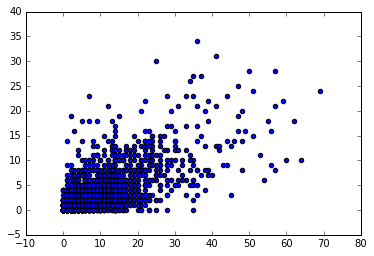

In [84]:
plt.scatter(timeless_data['***'],timeless_data['**'])

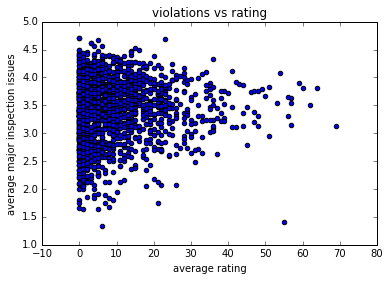

In [85]:
plt.scatter(timeless_data['***'],timeless_data['average'])
plt.title('violations vs rating')
plt.xlabel('average rating')
plt.ylabel('average major inspection issues')


In [86]:
list(timeless_data.columns)

['text',
 'restaurant_id',
 'x',
 'y',
 'crimes_2_km',
 'crimes_1_km',
 'crimes_500_m',
 'crimes_250_m',
 'crimes_100_m',
 'restaurants_2_km',
 'restaurants_1_km',
 'restaurants_500_m',
 'restaurants_250_m',
 'restaurants_100_m',
 'Caters',
 'review_count',
 'Outdoor Seating',
 'Has TV',
 'Delivery',
 'Coat Check',
 'BYOB',
 'stars',
 'Takes Reservations',
 'Wheelchair Accessible',
 'Good For Dancing',
 'Good For Kids',
 'Happy Hour',
 'Corkage',
 'Price Range',
 'open',
 'Take-out',
 'Waiter Service',
 'Order at Counter',
 'Good For Groups',
 'Parking_garage',
 'Parking_lot',
 'Parking_validated',
 'Parking_valet',
 'Parking_street',
 'Dietary Restrictions_vegetarian',
 'Music_jukebox',
 'Music_background_music',
 'Music_live',
 'Music_dj',
 'categories_Arts & Entertainment',
 'categories_Pubs',
 'categories_French',
 'categories_Thai',
 'categories_Latin American',
 'categories_Food',
 'categories_Bars',
 'categories_Sports Bars',
 'categories_Pizza',
 'categories_Restaurants',
 'cat

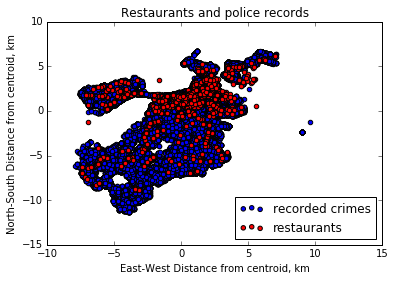

In [87]:
plt.scatter(cxy.x,cxy.y, c = 'b', label = 'recorded crimes')
plt.scatter(timeless_data.x,timeless_data.y, c = 'r', label = 'restaurants')
plt.title('Restaurants and police records')
plt.xlabel('East-West Distance from centroid, km')
plt.ylabel('North-South Distance from centroid, km')
plt.legend(loc = 'lower right')


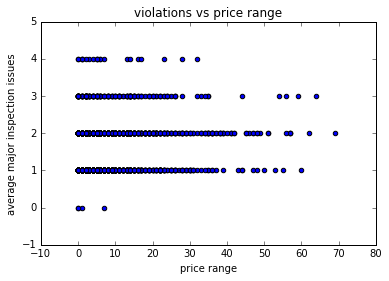

In [88]:
plt.scatter(timeless_data['***'],timeless_data['Price Range'])
plt.title('violations vs price range')
plt.xlabel('price range')
plt.ylabel('average major inspection issues')


train 0.898722627737
test 0.906581740977
auc 0.867866458007


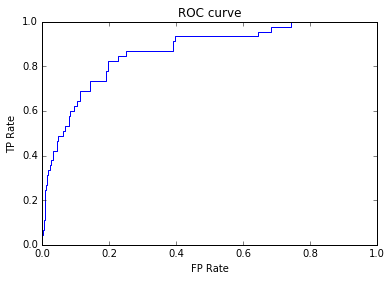

In [129]:
X = timeless_data['text']
y = ptransform(scoreapprox(timeless_data),90)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)
modelt = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = True,
                                          stop_words = 'english')), # , max_df = 0.95, min_df = 0.05,
                 ('tfidf', TfidfTransformer()), 
                 ('model', LogisticRegression()),])
modelt.fit(X_train,y_train)

pred_vals = modelt.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(modelt.score(X_train,y_train)))
print('test '+ str(modelt.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
plt.figure()

In [130]:
tpreds_train = modelt.predict_proba(X_train)[:,1]
tpreds_test = modelt.predict_proba(X_test)[:,1]

LogReg
train 0.91697080292
test 0.910828025478
auc 0.835785080856
NaiveBayes
train 0.648722627737
test 0.619957537155
auc 0.807616066771
RF
train 0.985401459854
test 0.912951167728
auc 0.813249869588
XGB
train 0.954379562044
test 0.904458598726
auc 0.867031820553


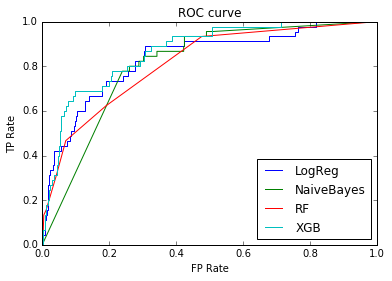

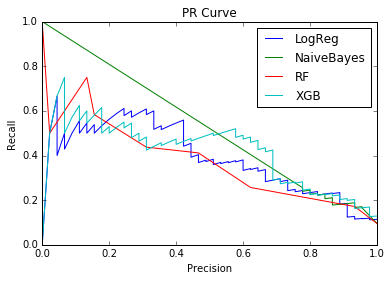

In [131]:
#basic non-text
X = timeless_data[tc_not_text_feats]
y = ptransform(scoreapprox(timeless_data), 90)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train, y_train)
    pred_vals = model.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [132]:
modelnt = models_pleasework[3]
ntpreds_train = modelnt.predict_proba(X_train)[:,1]
ntpreds_test = modelnt.predict_proba(X_test)[:,1]

In [330]:
X_train2 = pd.DataFrame(tpreds_train, columns = ['t'])
X_train2['nt'] = ntpreds_train
X_test2 = pd.DataFrame(tpreds_test, columns = ['t'])
X_test2['nt'] = ntpreds_test

LogReg
train 0.964416058394
test 0.908704883227
auc 0.877203964528
NaiveBayes
train 0.964416058394
test 0.900212314225
auc 0.879212310902
RF
train 0.998175182482
test 0.900212314225
auc 0.782159624413
XGB
train 0.986313868613
test 0.904458598726
auc 0.873082942097


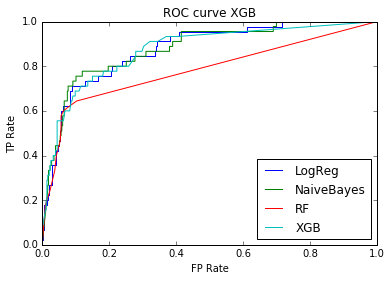

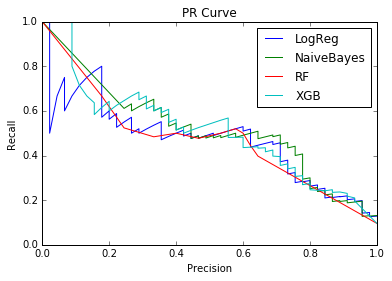

In [358]:
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_ensemble = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train2, y_train)
    pred_vals = model.predict_proba(X_test2)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train2,y_train)))
    print('test '+ str(model.score(X_test2,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_ensemble.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_ensemble)):
    model = models_ensemble[i]
    pred_vals = model.predict_proba(X_test2)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [359]:
goodmodel = models_ensemble[1]

train 0.964416058394
test 0.900212314225
auc 0.879212310902


(0, 1)

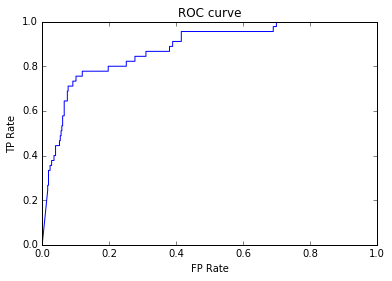

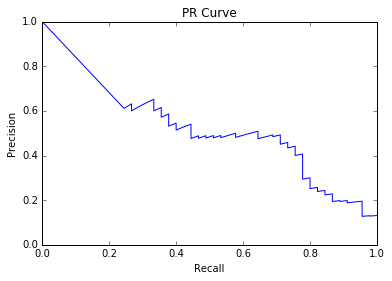

In [372]:
pred_vals = goodmodel.predict_proba(X_test2)
roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(goodmodel.score(X_train2,y_train)))
print('test '+ str(goodmodel.score(X_test2,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.xlim(([0,1]))
plt.ylim(([0,1]))
precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
plt.figure()
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)
plt.xlim(([0,1]))
plt.ylim(([0,1]))

In [419]:
prc = pd.DataFrame(precision, columns = ['p'])
prc['r'] = recall
# prc['t'] = thresholds

In [420]:
prc[prc.p>0.6]

,p,r
308,0.615385,0.355556
310,0.652174,0.333333
311,0.636364,0.311111
312,0.619048,0.288889
314,0.631579,0.266667
315,0.611111,0.244444
316,1.000000,0.000000


In [421]:
threshold = thresholds[310]#confirmed matching index

In [422]:
preds_test = goodmodel.predict(X_test2).tolist()

In [423]:
timeless_train, timeless_test, ytr, yte = constsplit(timeless_data.restaurant_id, timeless_data, y)

In [424]:
timeless_train['actual'] = y_train

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [450]:
timeless_train['actual'] = y_train.values.tolist()
timeless_test['actual'] = y_test.values.tolist()
timeless_train['predicted'] = goodmodel.predict(X_train2).tolist()
timeless_test['predicted'] = goodmodel.predict(X_test2).tolist()
timeless_train['prob'] = goodmodel.predict_proba(X_train2)[:,1].tolist()
timeless_test['prob'] = goodmodel.predict_proba(X_test2)[:,1].tolist()
timeless_train['predthresh'] = (timeless_train['prob'] >= threshold) + 0
timeless_test['predthresh'] = (timeless_test['prob'] >= threshold) + 0
# timeless_train['predone'] = (timeless_train['prob'] >= 1) + 0
# timeless_test['predone'] = (timeless_test['prob'] >= 1) + 0

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [552]:
oneones = timeless_test[timeless_test.prob >= 1]
oneones.actual.mean()

0.6666666666666666

In [555]:
meanscore = scoreapprox(timeless_test).mean()
actuals = timeless_test[timeless_test.actual == 1]
actuals['ind'] = list(range(1,len(actuals)+1))
ones = timeless_test[timeless_test.prob >= threshold]
FPs = ones[ones.actual != 1]
TPs = actuals[actuals.prob >= threshold]
FNs = actuals[actuals.prob < threshold]
TNs = timeless_test[timeless_test.actual == 0]
TNs = timeless_test[timeless_test.prob < threshold]

# predx, predy = predones.ind, scoreapprox(predones)/scoreapprox(actuals).max()
# missed = actuals[actuals.prob < 1]
# missx, missy = missed.ind, scoreapprox(missed)/scoreapprox(actuals).max()


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [556]:
scoreapprox(actuals).mean()

263.6666666666667

In [542]:
scoreapprox(FPs).median()

73.5

In [543]:
scoreapprox(timeless_test).median()

58.0

In [549]:
sum(scoreapprox(FPs) < 58)

3

In [539]:
print('TN: ' + str(len(TNs)) + '    FN: ' + str(len(FNs)))
print('FP: ' + str(len(FPs)) + '      TP: ' + str(len(TPs)))

TN: 448    FN: 30
FP: 8      TP: 15


In [529]:
confusion_matrix(timeless_test.actual, (timeless_test.prob >= threshold))

array([[418,   8],
       [ 30,  15]])

In [525]:
len(ones)/len(predones)

1.5

In [523]:
predones

,text,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,...,*>0,***>0,***>0,actual,predicted,prob,predthresh,scoreapprox,predone,ind
101,"the first time i went there it was ok, everyth...",rYuTG2Cs0qFL4blQHnoUCw,1.749169,1.863641,0.140,0.087,0.058,0.038,0.012,0.350259,...,18,6,11,1,1,1.0,1,207,1,2
185,The taste of pho was delicious. Just the way I...,1sTikFYBH0LGM_Zqd1ZVnw,-0.449427,1.281258,0.117,0.072,0.046,0.023,0.010,0.207254,...,28,17,19,1,1,1.0,1,306,1,5


In [465]:
predy.mean()/missy.mean()

1.2396045681986656

In [469]:
len(predones)/len(actuals)

0.3392857142857143

In [466]:
len(predy)/(len(predy) + len(missy))

0.3392857142857143

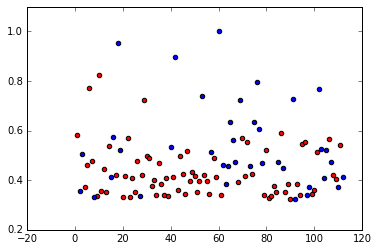

In [462]:
plt.scatter(missx, missy, c = 'r')
plt.scatter(predx, predy, c = 'b')

In [458]:
ymiss = scoreapprox(missed).values.tolist()
xmiss = list(range(1,len(ymiss)+1))
yhit = scoreapprox(predones).values.tolist()
xhit = list(range(1,len(yhit)+1))

In [519]:
scoreapprox(predones).mean()/scoreapprox(missed).mean()

1.2396045681986656

In [521]:
scoreapprox(predones).mean()/scoreapprox(timeless_test).mean()

3.813410234089185

In [432]:
want = (timeless_test.actual == 1) * (timeless_test.predthresh == 1) * (timeless_test.stars >= 4)

//anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [433]:
timeless_test[['restaurant_id', 'actual', 'predthresh', 'prob','stars']][want]

,restaurant_id,actual,predthresh,prob,stars
185,1sTikFYBH0LGM_Zqd1ZVnw,1,1,1.0,4.0
650,C_a6h-YdYPFDAX_3YJUTIA,1,1,1.0,4.0
722,sMrgQD2dYrvbe6VoZubSCg,1,1,1.0,4.0
1270,g3mb9okPoX9hlobP70Ib0g,1,1,1.0,4.0
1342,MiOurH3MHs6CwA6iOWehOQ,1,1,1.0,4.0
1429,SAyuXU4hbh5iLKHn824YZg,1,1,1.0,4.0


In [434]:
timeless_test['scoreapprox'] = scoreapprox(timeless_test)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [435]:
tt = timeless_test.copy()
tt = tt.sort_values(by = 'scoreapprox', ascending = False)

In [436]:
td2a = timeless_data.copy()
td2a['scoreval'] = scoreapprox(td2a)
td2a = td2a.sort_values(by = 'scoreval', ascending = False)
td2a['indval'] = list(range(1,len(td2a)+1))
td2aval = td2a[td2a['restaurant_id'] == '1sTikFYBH0LGM_Zqd1ZVnw']
td2aval.indval

185    38
Name: indval, dtype: int64

In [437]:
tt.columns.values.tolist()

['text',
 'restaurant_id',
 'x',
 'y',
 'crimes_2_km',
 'crimes_1_km',
 'crimes_500_m',
 'crimes_250_m',
 'crimes_100_m',
 'restaurants_2_km',
 'restaurants_1_km',
 'restaurants_500_m',
 'restaurants_250_m',
 'restaurants_100_m',
 'Caters',
 'review_count',
 'Outdoor Seating',
 'Has TV',
 'Delivery',
 'Coat Check',
 'BYOB',
 'stars',
 'Takes Reservations',
 'Wheelchair Accessible',
 'Good For Dancing',
 'Good For Kids',
 'Happy Hour',
 'Corkage',
 'Price Range',
 'open',
 'Take-out',
 'Waiter Service',
 'Order at Counter',
 'Good For Groups',
 'Parking_garage',
 'Parking_lot',
 'Parking_validated',
 'Parking_valet',
 'Parking_street',
 'Dietary Restrictions_vegetarian',
 'Music_jukebox',
 'Music_background_music',
 'Music_live',
 'Music_dj',
 'categories_Arts & Entertainment',
 'categories_Pubs',
 'categories_French',
 'categories_Thai',
 'categories_Latin American',
 'categories_Food',
 'categories_Bars',
 'categories_Sports Bars',
 'categories_Pizza',
 'categories_Restaurants',
 'cat

In [438]:
tt['Price Range'].value_counts()

2    220
1    190
3     55
4      6
Name: Price Range, dtype: int64

In [439]:
tt.stars.value_counts()

3.5    155
4.0    129
3.0    106
2.5     49
4.5     19
2.0     12
1.5      1
Name: stars, dtype: int64

In [440]:
ttbads = tt[tt.stars > 3.5]
ttbads = ttbads[ttbads['Price Range'] > 1]
ttbads = ttbads[ttbads.prob > 0.7]
ttbads = ttbads[ttbads.actual == 1]

ttbads

,text,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,...,**,***,*>0,***>0,***>0,actual,predicted,prob,predthresh,scoreapprox
722,The waitress is very rude and very stiff. They...,sMrgQD2dYrvbe6VoZubSCg,1.775881,1.918154,0.142,0.088,0.060,0.043,0.014,0.353368,...,14,46,17,7,12,1,1,1.0,1,363
650,A bit pricey but you get what you pay for. Gre...,C_a6h-YdYPFDAX_3YJUTIA,0.517165,1.430442,0.146,0.096,0.046,0.023,0.006,0.276166,...,10,64,22,10,25,1,1,1.0,1,316
185,The taste of pho was delicious. Just the way I...,1sTikFYBH0LGM_Zqd1ZVnw,-0.449427,1.281258,0.117,0.072,0.046,0.023,0.010,0.207254,...,21,41,28,17,19,1,1,1.0,1,306
1342,The No Name Chicken was amazing! I was very im...,MiOurH3MHs6CwA6iOWehOQ,-4.552764,2.169791,0.058,0.038,0.021,0.012,0.004,0.091710,...,16,47,16,11,10,1,1,1.0,1,305
1270,Meh. Kind of just...there. Spring rolls were h...,g3mb9okPoX9hlobP70Ib0g,-0.442047,1.318820,0.116,0.072,0.046,0.029,0.009,0.208290,...,13,42,21,9,18,1,1,1.0,1,287
1429,My pad see ew is bursting with flavor! I just ...,SAyuXU4hbh5iLKHn824YZg,1.584797,1.920329,0.146,0.084,0.059,0.039,0.023,0.360622,...,5,20,20,5,7,1,1,1.0,1,263


In [355]:
sum(timeless_test.prob == 1)/len(timeless_test)

0.006369426751592357

In [221]:
tt[tt.restaurant_id == 'sMrgQD2dYrvbe6VoZubSCg']

,text,restaurant_id,x,y,crimes_2_km,crimes_1_km,crimes_500_m,crimes_250_m,crimes_100_m,restaurants_2_km,...,**,***,*>0,***>0,***>0,actual,predicted,prob,score,scoreapprox
722,The waitress is very rude and very stiff. They...,sMrgQD2dYrvbe6VoZubSCg,1.775881,1.918154,0.142,0.088,0.06,0.043,0.014,0.353368,...,14,46,17,7,12,1,1,0.8,363,363


In [162]:
T = (preds_test == y_test)
TP = y_test[T] == 1
# tdTP = timeless_data[TP]
# tdTP



//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


IndexingError: Unalignable boolean Series key provided

In [ ]:
stop here

In [141]:
overlap_feats = list(set(tc_not_text_feats).intersection(all_non_text_feats))
set(overlap_feats) == set(tc_not_text_feats)

True

# #models already trained
# def combinefeats(model1,model2,X_train, X_test,feats1,feats2):
#     X_train_2 = pd.DataFrame(model1.predict_proba(X_train[feats1])[:,1], columns = ['model1'])
#     X_train_2['model2'] = model2.predict_proba(X_train[feats2])[:,1]
#     X_test_2 = pd.DataFrame(model1.predict_proba(X_test[feats1])[:,1], columns = ['model1'])
#     X_test_2['model2'] = model2.predict_proba(X_test[feats2])[:,1]
#     return X_train_2, X_test_2

# Just use this model it's fine

In [94]:
X = timeless_data['text']
y = scoreapprox(timeless_data)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)
modelr = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = True,
                                          stop_words = 'english')), # , max_df = 0.95, min_df = 0.05,
                 ('tfidf', TfidfTransformer()), 
                 ('model', LinearRegression()),])
modelr.fit(X_train,y_train)

# pred_vals = modelt.predict_proba(X_test)
# roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(modelr.score(X_train,y_train)))
print('test '+ str(modelr.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# plt.plot(roc[0], roc[1])
# plt.title('ROC curve')
# plt.xlabel('FP Rate')
# plt.ylabel('TP Rate')
# precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
# plt.figure()

train 1.0
test 0.2042906844


In [480]:
coefs = list(modelt.named_steps['model'].coef_[0])
features = modelt.named_steps['vect'].get_feature_names()

In [481]:
cf, cdict = [], {}
for i in range(len(coefs)):
    cf.append((coefs[i], features[i]))
    cdict[features[i]] = coefs[i]
cf.sort(reverse = True)
positives = cf[:100]
negatives = cf[-100:]
negatives.sort()

In [491]:
print()
print('"Dirty" Words:\n')

for line in positives[:10]:
    num = str(round(line[0],3))
    num = num + '0' * (5 - len(num))
    print(line[1] + ': ' + num)
print()


"Dirty" Words:

sushi: 1.728
pho: 1.657
food: 1.614
chinese: 1.197
rice: 0.985
thai: 0.885
dim sum: 0.868
good: 0.775
noodles: 0.716
indian: 0.715



In [492]:
print()
print('"Clean" words:\n')

for line in negatives[:10]:
    num = str(round(line[0],3))
    num = num + '0' * (5 - len(num))
    print(line[1] + ': ' + num)
print()


"Clean" words:

coffee: -0.577
italian: -0.503
pasta: -0.474
north end: -0.456
burger: -0.446
burrito: -0.426
pizza: -0.415
north: -0.41
sandwich: -0.316
starbucks: -0.284



In [295]:
coefs = list(models_pleasework[0].coef_[0])
features= tc_not_text_feats

In [296]:
# for i in range(len(coefs)):
#     if type(cf[i][1]) not in [float,int,complex]:
#         print(i)
#         print(cf[i][0])
#         print()

In [297]:
cf, cdict = [], {}
for i in range(len(coefs)):
    cf.append((coefs[i], features[i]))
    cdict[features[i]] = coefs[i]
cf.sort(reverse = True)
positives = cf[:100]
negatives = cf[-100:]
negatives.sort()

In [299]:
for line in positives[:10]:
    num = str(round(line[0],3))
    print(line[1] + ': ' + num)

Waiter Service: 1.288
categories_Chinese: 1.195
Parking_validated: 1.119
Happy Hour: 1.054
categories_Sushi Bars: 0.997
Ambience_divey: 0.992
open: 0.983
Ambience_casual: 0.804
Coat Check: 0.755
neighborhoods_South End: 0.72


In [301]:
for line in negatives[:10]:
    num = str(round(line[0],3))
    print(line[1] + ': ' + num)

city_Brighton: -1.386
Good For Dancing: -1.289
categories_Sandwiches: -1.219
neighborhoods_North End: -1.167
neighborhoods_East Boston: -1.09
categories_Lounges: -1.001
categories_Mexican: -0.956
average: -0.937
categories_Burgers: -0.851
neighborhoods_Allston/Brighton: -0.794


In [311]:
modelnt.

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [236]:
hygb = ['gross', 'mess', 'sticky', 'smell', 'restroom', 'dirty', 'bug', 'spider', 'gross', 'disgusting', 'clean', 'dirty', 'dirt', 'ew', 'eww', 'roach', 'cleanliness', 'hygeine', 'raw']
ingb = ['beef', 'pork', 'noodle', 'egg', 'sushi', 'ramen', 'pho', 'bread', 'toast','carrot','bagel','sandwich']
cuib = ['Vietnamese', 'Thai', 'Mexican', 'Japanese', 'Chinese', 'American', 'Pizza', 'Sushi', 
        'Indian', 'Italian', 'Asian']
for word in ingb:
    if word.lower() in cdict.keys():
        print(word.lower() + ': ' + str(cdict[word.lower()]))

beef: 0.606690478699
pork: 0.231558756852
noodle: 0.62101943809
egg: 0.0283205641651
soy: 0.192289307632
ramen: -0.194967802056
pho: 1.65725905561
bread: -0.243544045219
toast: 0.175316269795
carrot: -0.00889168310484
bagel: -0.263147010037
sandwich: -0.316454911813


In [517]:
badwords = ['bug', 'spider', 'slime', 'sticky', 'gross', 'disgusting', 'dirty', 'clean', 'smelly', 'ew',
             'egg', 'raw', 'uncooked', 'health', 'vomit', 'puke', 'chinese', 'cooked',
           'fresh', 'spaghetti', 'politics', 'weak', 'arms', 'heavy']

hygb = ['gross', 'mess', 'sticky', 'smell', 'restroom', 'dirty']
ingb = ['beef', 'pork', 'noodle', 'egg', 'soy', 'ramen', 'pho']
cuib = ['Vietnamese', 'Thai', 'Mexican', 'Japanese', 'Chinese', 'American', 'Pizza', 'Sushi', 
        'Indian', 'Italian', 'Asian']

sentimentwords = ['good', 'bad', 'great', 'nice', 'delicious', 'yummy', 'tasty', 'weird']

print('Hygeine Words:\n')

for word in badwords:
    if word.lower() in cdict.keys():
        num = str(round(cdict[word.lower()],3))
        num = num + '0' * (5 - len(num))
        print(word + ': ' + num)

Hygeine Words:

bug: 0.037
spider: 0.032
slime: 0.005
sticky: 0.231
gross: 0.065
disgusting: 0.044
dirty: 0.066
clean: 0.018
smelly: 0.035
ew: 0.056
egg: 0.028
raw: 0.077
uncooked: 0.046
health: 0.033
vomit: 0.044
puke: -0.007
chinese: 1.197
cooked: 0.057
fresh: 0.048
spaghetti: -0.052
politics: 0.004
weak: 0.015
arms: -0.008
heavy: 0.007


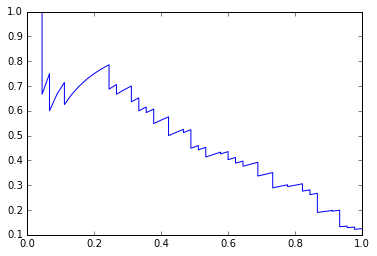

In [91]:
plt.plot(recall, precision)

train 0.909501915709
test 0.918303075213
auc 0.612454866958


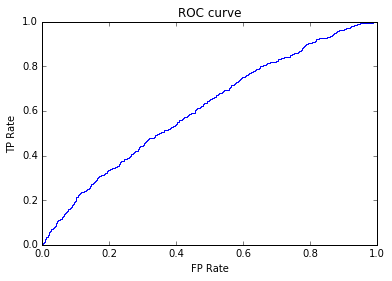

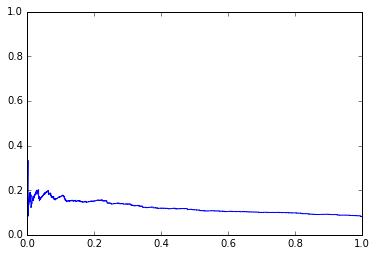

In [93]:
X = windows_data['text']
y = ptransform(scoreapprox(windows_data),90)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)
modelt = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = True,
                                          stop_words = 'english')), # , max_df = 0.95, min_df = 0.05,
                 ('tfidf', TfidfTransformer()), 
                 ('model', LogisticRegression()),])
modelt.fit(X_train,y_train)

pred_vals = modelt.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(modelt.score(X_train,y_train)))
print('test '+ str(modelt.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
plt.figure()
plt.plot(recall, precision)

# Get score without text features, then throw that and pca in to ID others.

# Marwin's stuff

In [ ]:
# import numpy as np
# from sklearn.base import clone
# from itertools import combinations
# from sklearn.cross_validation import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score
# class SBS():
#     def __init__(self, model, k_features,scoring_metric=accuracy_score, test_size=0.2, random_state=42):
#         self.scoring_metric = scoring_metric
#         self.model = clone(model)
#         self.k_features = k_features
#         self.test_size = test_size
#         self.random_state = random_state
        
#     def fit(self,X,y, ids):
#         X_train,X_test,y_train,y_test = constsplit(ids, X, y)
#         dim = X_train.shape[1]
#         self.indices_ = tuple(range(dim))
#         self.subsets_ = [self.indices_]
#         score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
#         self.scores_ = [score]
        
#         while dim > self.k_features:
#             scores = []
#             subsets = []
            
#             for p in combinations(self.indices_,r=dim-1):
#                 score = self._calc_score(X_train,y_train,X_test,y_test,p)
#                 scores.append(score)
#                 subsets.append(p)

#             best = np.argmax(scores)
#             self.indices_ = subsets[best]
#             self.subsets_.append(self.indices_)
#             dim -= 1
#             self.scores_.append(scores[best])
#         self.k_score_ = self.scores_[-1]
#         return self
    
#     def transform(self,X):
#         return X[:,self.indices_]
    
#     def _calc_score(self,X_train,y_train,X_test,y_test,indices):
#         results = self.model.fit(X_train[:,indices],y_train)
#         #regression scoring
# #        score = results.score(X_test[:,indices],y_test) 
# #        score = np.mean(self.scoring_metric(self.model,X_train,y_train,scoring='r2'))
#         #classification scoring
#         y_pred = self.model.predict(X_test[:,indices])
#         score = self.scoring_metric(y_test,y_pred)
#         return score 

In [136]:
    # def score(model,Xte,yte, class_or_reg):
    #     out = model.score(Xte,yte)
    #     if class_or_reg == 'class':
    #         pred_vals = model.predict_proba(Xte)
    #         out = roc_auc_score(yte, pred_vals[:,1])    
    #     return out

    # def onelevel(Xtr, Xte, ytr, yte, mycols, model, class_or_reg):
    #     if type(mycols) == list:
    #         columns = mycols
    #     else:
    #         columns = list(mycols)
    #     model.fit(Xtr, ytr)
    #     allscore = score(model,Xte,yte, class_or_reg)
    #     bestscore = allscore + 0
    #     bestcols = mycols[:]
    #     for column in columns:
    #         innercols = columns[:]
    #         innercols.remove(column)
    #         model.fit(Xtr[innercols], ytr)
    #         innerscore = score(model,Xte[innercols],yte, class_or_reg)
    #         if innerscore > bestscore:
    #             bestscore = innerscore
    #             bestcols = innercols
    #     return bestcols

    # def movedown(Xtr, Xte, ytr, yte, mycols, model, class_or_reg):
    #     colsteps = [mycols[:]]
    #     colsteps.append(onelevel(Xtr, Xte, ytr, yte, colsteps[-1], model, class_or_reg))
    #     keep_going = True - (colsteps[-1] == colsteps[-2])
    #     while keep_going == True:
    # #         lastcols = nextcols[:]
    #         colsteps.append(onelevel(Xtr, Xte, ytr, yte, colsteps[-1], model, class_or_reg))
    #         keep_going = keep_going - (colsteps[-1] == colsteps[-2])
    #     return colsteps


In [138]:
# def onelevelup(Xtr, Xte, ytr, yte, allcols, chosencols, model, class_or_reg):
#     othercols = list(set(allcols).difference(set(chosencols)))
#     outcols = chosencols[:]
#     outerscore = -1
#     to_add = None
#     if len(chosencols) > 0:
#         model.fit(Xtr[chosencols], ytr)
#         outerscore = score(model, Xte[chosencols], yte, class_or_reg)
#     for column in othercols:
#         currentcols = chosencols[:]
#         currentcols.append(column)
#         model.fit(Xtr[currentcols], ytr)
#         innerscore = score(model, Xte[currentcols], yte, class_or_reg)
#         if innerscore > outerscore:
#             outerscore = innerscore
#             to_add = column
#     if to_add:
#         outcols.append(to_add)
#     return outcols

# def moveup(Xtr, Xte, ytr, yte, allcols, model, class_or_reg):
#     colsteps = [[]]
#     colsteps.append(onelevelup(Xtr, Xte, ytr, yte, allcols, colsteps[-1], model, class_or_reg))
#     keep_going = True - (colsteps[-1] == colsteps[-2])
#     while keep_going == True:
#         colsteps.append(onelevelup(Xtr, Xte, ytr, yte, allcols, colsteps[-1], model, class_or_reg))
#         keep_going = keep_going - (colsteps[-1] == colsteps[-2])
#     return colsteps

In [139]:
# #non-text
# X = timeless_data[tc_not_text_feats]
# y = scoreapprox(timeless_data)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)
# # t0 = time.time()
# # colpath = movedown(X_train, X_test, y_train, y_test, list(X_train.columns), LinearRegression(), 'reg')
# # colpath2 = moveup(X_train, X_test, y_train, y_test, colpath[-1], LinearRegression(), 'reg')
# # print(time.time() - t0)

In [140]:
# def updown(Xtr, Xte, ytr, yte, allcols, model, class_or_reg, n_cycles):
# #     colsteps_up = moveup(Xtr, Xte, ytr, yte, allcols, model, class_or_reg)
#     stepcols = [allcols[:]]
#     stepcols.append(movedown(Xtr, Xte, ytr, yte, stepcols[-1], model, class_or_reg)[-1])
#     stepcols.append(moveup(Xtr, Xte, ytr, yte, stepcols[-1], model, class_or_reg)[-1])
#     i = 1
#     keep_going = (True - (stepcols[-1] == stepcols[-3])) * (True - (i > n_cycles))
#     while keep_going == True:
#         stepcols.append(movedown(Xtr, Xte, ytr, yte, stepcols[-1], model, class_or_reg)[-1])
#         stepcols.append(moveup(Xtr, Xte, ytr, yte, stepcols[-1], model, class_or_reg)[-1])
#         keep_going = (True - (stepcols[-1] == stepcols[-3])) * (True - (i > n_cycles))
#         i = i + 1
#     lens = []
#     for col in stepcols:
#         lens.append(len(col))
#     return stepcols, lens, (True - (stepcols[-1] == stepcols[-3])), (True - (i > n_cycles)), i, keep_going
    

In [ ]:
# t0 = time.time()
# colpath3, lens, a, b, c, d = updown(X_train, X_test, y_train, y_test, list(X_train.columns), LinearRegression(), 'reg', 1)
# print(time.time() - t0)
# print([a,b, c, d])

In [ ]:
# # non-text reg

# X = timeless_data[colpath3[-1]]
# y = scoreapprox(timeless_data)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# regression_models = [LinearRegression(), Ridge(alpha = 0.1), ElasticNet(), Lasso(), rfr(), SVR()]
# modelnames = ['LinReg','Ridge','ElasticNet','Lasso', 'RF', 'SVR']
# models_pleasework = []
# for i in range(len(modelnames)):
#     model = regression_models[i]
#     model.fit(X_train, y_train)
# #     pred_vals = model.predict_proba(X_test[tc_not_text_feats])
# #     roc = roc_curve(y_test, pred_vals[:,1])
#     print(modelnames[i])
#     print('train '+ str(model.score(X_train,y_train)))
#     print('test '+ str(model.score(X_test,y_test)))

In [ ]:
# t0 = time.time()
# colpath5, lens, a, b, c, d = updown(X_train, X_test, y_train, y_test, list(X_train.columns), rfr(), 'reg', 1)
# print(time.time() - t0)
# print([a,b, c, d])

In [ ]:
# colpath5[-1]

In [ ]:
# X = timeless_data[tc_not_text_feats]
# y = ptransform(scoreapprox(timeless_data), 80)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

In [ ]:
# t0 = time.time()
# colpath6, lens, a, b, c, d = updown(X_train, X_test, y_train, y_test, list(X_train.columns), LogisticRegression(), 'class', 1)
# print(time.time() - t0)
# print([a,b, c, d])

In [ ]:
# colpath6[-1]

# updown actually goes in deterministic cycles

In [ ]:
# #non-text
# xtctc = colpath6[-1][:]
# xtctc.append('text')
# X = timeless_data[xtctc]
# y = ptransform(scoreapprox(timeless_data), 80)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
# modelnames = ['LogReg','NaiveBayes','RF','XGB']
# models_pleasework = []
# for i in range(4):
#     model = classification_models[i]
#     model.fit(X_train[colpath6[-1]], y_train)
#     pred_vals = model.predict_proba(X_test[colpath6[-1]])
#     roc = roc_curve(y_test, pred_vals[:,1])
#     print(modelnames[i])
#     print('train '+ str(model.score(X_train[colpath6[-1]],y_train)))
#     print('test '+ str(model.score(X_test[colpath6[-1]],y_test)))
#     print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.plot(roc[0], roc[1], label = modelnames[i])
#     plt.title('ROC curve ' + modelnames[i])
#     plt.xlabel('FP Rate')
#     plt.ylabel('TP Rate')
#     models_pleasework.append(model)
# plt.legend(loc = 'best')  
# plt.figure()
# plt.title('PR Curve')
# plt.xlabel('Precision')
# plt.ylabel('Recall')
# for i in range(len(models_pleasework)):
#     model = models_pleasework[i]
#     pred_vals = model.predict_proba(X_test[colpath6[-1]])
#     precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
#     plt.plot(recall, precision, label = modelnames[i])
# plt.legend(loc = 'best')

# toy set of inspection-level estimates

In [ ]:
# wd2=windows_data.sample(n = 1000)
# testmodel = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = False, stop_words = 'english')),
#                  ('model', Ridge()),])

# X = wd2['text']
# y = scoreapprox(wd2)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
# wd2=windows_data.sample(n = 1000)
# testmodel = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = False, stop_words = 'english')),
#                  ('model', LogisticRegression()),])

# X = wd2['text']
# y = ptransform(scoreapprox(wd2),80)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# t0 = time.time()
# testmodel.fit(X_train, y_train)
# pred_vals = testmodel.predict_proba(X_test)
# roc = roc_curve(y_test, pred_vals[:,1])
# print(modelnames[i])
# print('train '+ str(testmodel.score(X_train,y_train)))
# print('test '+ str(testmodel.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# plt.plot(roc[0], roc[1], label = modelnames[i])
# plt.title('ROC curve ' + modelnames[i])
# plt.xlabel('FP Rate')
# plt.ylabel('TP Rate')
# print(time.time()-t0)


In [ ]:
# testmodel = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = False, stop_words = 'english')),
#                  ('model', LogisticRegression()),])

# X = timeless_data['text']
# y = ptransform(scoreapprox(timeless_data),80)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# t0 = time.time()
# testmodel.fit(X_train, y_train)
# pred_vals = testmodel.predict_proba(X_test)
# roc = roc_curve(y_test, pred_vals[:,1])
# print(modelnames[i])
# print('train '+ str(testmodel.score(X_train,y_train)))
# print('test '+ str(testmodel.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# plt.plot(roc[0], roc[1], label = modelnames[i])
# plt.title('ROC curve ' + modelnames[i])
# plt.xlabel('FP Rate')
# plt.ylabel('TP Rate')
# print(time.time()-t0)


In [ ]:
# testmodel = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = False, stop_words = 'english')),
#                  ('model', LogisticRegression()),])

# X = timeless_data['text']
# y = ptransform(scoreapprox(timeless_data),80)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# t0 = time.time()
# testmodel.fit(X_train, y_train)
# pred_vals = testmodel.predict_proba(X_test)
# roc = roc_curve(y_test, pred_vals[:,1])
# print(modelnames[i])
# print('train '+ str(testmodel.score(X_train,y_train)))
# print('test '+ str(testmodel.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# plt.plot(roc[0], roc[1], label = modelnames[i])
# plt.title('ROC curve ' + modelnames[i])
# plt.xlabel('FP Rate')
# plt.ylabel('TP Rate')
# print(time.time()-t0)


In [ ]:
# modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
# modelnames = ['LogReg','NaiveBayes','RF','XGB']

# for i in range(len(modeltypes)):

#     wd2=windows_data.sample(n = 1000)
#     pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), lowercase = False, stop_words = 'english'))])
#     testmodel = modeltypes[i]
#     train_stuff = pipe.fit_transform(X_train).todense()
#     test_stuff = pipe.transform(X_test).todense()
#     X = wd2['text']
#     y = ptransform(scoreapprox(wd2),80)
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
#     t0 = time.time()
#     testmodel.fit(train_stuff, y_train)
#     pred_vals = testmodel.predict_proba(test_stuff)
#     roc = roc_curve(y_test, pred_vals[:,1])
#     print(modelnames[i])
#     print('train '+ str(testmodel.score(train_stuff,y_train)))
#     print('test '+ str(testmodel.score(test_stuff,y_test)))
#     print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.plot(roc[0], roc[1], label = modelnames[i])
#     plt.title('ROC curve ' + modelnames[i])
#     plt.xlabel('FP Rate')
#     plt.ylabel('TP Rate')
# print(time.time()-t0)

In [ ]:
# testmodel.score(X_test, y_test)

In [ ]:
# colpath4[-1] == colpath4[-3]

In [ ]:
# plt.plot(list(range(1, len(lens) + 1)), lens)

In [ ]:
# train_test_split(X_t)

In [ ]:
# X = timeless_data[colpath[-1]]
# y = timeless_data['***']
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# regression_models = [LinearRegression(), Ridge(alpha = 0.1), ElasticNet(), Lasso(), rfr(), SVR()]
# modelnames = ['LinReg','Ridge','ElasticNet','Lasso', 'RF', 'SVR']
# models_pleasework = []
# for i in range(len(modelnames)):
#     model = regression_models[i]
#     model.fit(X_train, y_train)
# #     pred_vals = model.predict_proba(X_test[tc_not_text_feats])
# #     roc = roc_curve(y_test, pred_vals[:,1])
#     print(modelnames[i])
#     print('train '+ str(model.score(X_train,y_train)))
#     print('test '+ str(model.score(X_test,y_test)))

In [ ]:
# # non-text classifier
# t0 = time.time()
# X = timeless_data[tc_not_text_feats]
# y = ptransform(timeless_data['***'], 80)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# colpath_lr = movedown(X_train, X_test, y_train, y_test, list(X_train.columns), LogisticRegression(), 'class')
# print(str(len(colpath_lr) - 1) + ' steps, ' +  str(time.time() - t0) + ' seconds')

In [ ]:
# onelevelup(X_train, X_test, y_train, y_test, list(X_train.columns), [], model, 'reg')

In [ ]:
# # non-text classifier
# t0 = time.time()
# X = timeless_data[tc_not_text_feats]
# y = ptransform(timeless_data['***'], 80)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# colpath_nb = movedown(X_train, X_test, y_train, y_test, list(X_train.columns), GaussianNB(), 'class')
# print(str(len(colpath_nb) - 1) + ' steps, ' +  str(time.time() - t0) + ' seconds')

In [ ]:
# colpath_nb[-1]

In [ ]:
# # non-text classifier
# t0 = time.time()
# X = timeless_data[tc_not_text_feats]
# y = ptransform(timeless_data['***'], 80)
# X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

# colpath_xgb = movedown(X_train, X_test, y_train, y_test, list(X_train.columns), xgb(), 'class')
# print(str(len(colpath_xgb) - 1) + ' steps, ' +  str(time.time() - t0) + ' seconds')

In [ ]:
# non-text classifier
t0 = time.time()
X = timeless_data[tc_not_text_feats]
y = ptransform(timeless_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

colpath_rf = movedown(X_train, X_test, y_train, y_test, list(X_train.columns), rf(), 'class')
print(str(len(colpath_rf) - 1) + ' steps, ' +  str(time.time() - t0) + ' seconds')

In [ ]:
#non-text
xtctc = tc_not_text_feats[:]
xtctc.append('text')
X = timeless_data[xtctc]
y = ptransform(scoreapprox(timeless_data), 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train[tc_not_text_feats], y_train)
    pred_vals = model.predict_proba(X_test[tc_not_text_feats])
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train[tc_not_text_feats],y_train)))
    print('test '+ str(model.score(X_test[tc_not_text_feats],y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(X_test[tc_not_text_feats])
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
plt.hist(scoreapprox(windows_data), bins = 30)

In [ ]:
plt.hist(scoreapprox(timeless_data), bins = 30)

In [ ]:
percentile(scoreapprox(windows_data),90)

In [ ]:
max(scoreapprox(windows_data))

In [ ]:
plt.hist(windows_data['***'], bins = 15)

In [ ]:
# non-text reg

X = timeless_data[tc_not_text_feats]
y = scoreapprox(timeless_data)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

regression_models = [LinearRegression(), Ridge(alpha = 0.1), ElasticNet(), Lasso(), rfr(), SVR()]
modelnames = ['LinReg','Ridge','ElasticNet','Lasso', 'RF', 'SVR']
models_pleasework = []
for i in range(len(modelnames)):
    model = regression_models[i]
    model.fit(X_train, y_train)
#     pred_vals = model.predict_proba(X_test[tc_not_text_feats])
#     roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))

In [ ]:
sbs = SBS(LinearRegression(), 20)

sbs.fit(X_train,y_train, timeless_data.restaurant_id)

In [ ]:
yta = np.asarray(y_test.values.tolist())

In [ ]:
mse

In [ ]:
plt.scatter(list(range(1,11)), y_test[:10].values.tolist(), c = 'b', label = 'true')
plt.scatter(list(range(1,11)), y_pred[:10], c = 'r', label = 'predicted')
plt.legend()

In [ ]:
randguess = 

In [ ]:
junky_feats = ['crimes_2_km', 'crimes_500_m', 'crimes_250_m', 'crimes_100_m', 'restaurants_2_km', 'restaurants_500_m', 'restaurants_250_m', 'restaurants_100_m', 'city_Allston', 'city_Dorchester', 'city_Jamaica Plain', 'city_Roslindale', 'city_West Roxbury', 'city_Boston', 'city_Brighton']
# junky_feats.extend(['x','y', 'neighborhoods_Dorchester', 'neighborhoods_Jamaica Plain', 'neighborhoods_Allston/Brighton', 'neighborhoods_Fenway', 'neighborhoods_Financial District', 'neighborhoods_South End', 'neighborhoods_Chinatown', 'neighborhoods_Back Bay', 'neighborhoods_East Boston', 'neighborhoods_Downtown', 'neighborhoods_Waterfront', 'neighborhoods_Charlestown', 'neighborhoods_North End', 'neighborhoods_Roslindale', 'neighborhoods_South Boston', 'neighborhoods_West Roxbury', 'neighborhoods_Beacon Hill',])
junky_feats.append('open')
tc_not_text_feats_short = tc_not_text_feats[:]
for jf in junky_feats:
    while jf in tc_not_text_feats_short:
        tc_not_text_feats_short.remove(jf)
# tc_not_text_feats_short

In [ ]:
# non-text only; fewer features

xtctc_short = tc_not_text_feats_short[:]
xtctc_short.append('text')
X = timeless_data[xtctc_short]
y = ptransform(timeless_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train[tc_not_text_feats_short], y_train)
    pred_vals = model.predict_proba(X_test[tc_not_text_feats_short])
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train[tc_not_text_feats_short],y_train)))
    print('test '+ str(model.score(X_test[tc_not_text_feats_short],y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(X_test[tc_not_text_feats_short])
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
# Non-text regression; fewer features

xtctc_short = tc_not_text_feats_short[:]
xtctc_short.append('text')
X = timeless_data[xtctc_short]
y = timeless_data['***']
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

regression_models = [LinearRegression(), Ridge(), ElasticNet(), Lasso(), rfr(), SVR()]
modelnames = ['LinReg','Ridge','ElasticNet','Lasso', 'RF', 'SVR']
models_pleasework = []
for i in range(len(modelnames)):
    model = regression_models[i]
    model.fit(X_train[tc_not_text_feats_short], y_train)
#     pred_vals = model.predict_proba(X_test[tc_not_text_feats_short])
#     roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train[tc_not_text_feats_short],y_train)))
    print('test '+ str(model.score(X_test[tc_not_text_feats_short],y_test)))

checking for colinearity in non text features

In [ ]:
svd = TruncatedSVD(n_components = 50)

X_train_short = svd.fit_transform(X_train[tc_not_text_feats[:]])
X_test_short = svd.transform(X_test[tc_not_text_feats[:]])

X_test_short.shape

In [ ]:


# non-text only
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train_short, y_train)
    pred_vals = model.predict_proba(X_test_short)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train_short,y_train)))
    print('test '+ str(model.score(X_test_short,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(X_test_short)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

Made worse, so try brute force

In [ ]:
# Add all music cols
muscols = ['Music_dj', 'Music_live', 'Music_background_music', 'Music_jukebox']
music = timeless_data[muscols[0]]
for col in muscols[1:]:
    music = music + timeless_data[col]
music.mean()

In [ ]:
dense_feats, sparse_feats = [], []
for col in tc_not_text_feats:
    filled = (timeless_data[col] != 0).mean()
    if filled > 0.03:
        dense_feats.append(col)
    else:
        sparse_feats.append(col)
sparse_feats

In [ ]:
tc_not_text_feats

In [ ]:
'text' in time_independent_feats[1:]

In [ ]:
timeless_data[['neighborhoods_South Boston', 'neighborhoods_Dorchester', 'neighborhoods_Jamaica Plain', 'neighborhoods_Waterfront', 'neighborhoods_Downtown', 'neighborhoods_Charlestown', 'neighborhoods_East Boston', 'neighborhoods_North End', 'neighborhoods_West Roxbury', 'neighborhoods_Back Bay', 'neighborhoods_Roslindale', 'neighborhoods_South End', 'neighborhoods_Allston/Brighton', 'neighborhoods_Fenway', 'neighborhoods_Financial District',
              'neighborhoods_Chinatown', 'neighborhoods_Beacon Hill']].sum()

In [ ]:
def fix_times(dataframe):
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']:
        topen

In [ ]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
            
def time_open(dataframe, mydays, prefix):
    cols_summed = []
    newname = prefix + '_time_open'
    for i in range(len(mydays)):
        day = mydays[i]
        topen, tclose = day+ '_open', day+ '_close'
        if (topen in dataframe.columns)*(tclose in dataframe.columns) == 1:
            diff = dataframe[tclose] - dataframe[topen]
            diff2 = diff + (diff < 0)*24
            if i > 0:
                dataframe[newname] = dataframe[newname] + diff2
            else:
                dataframe[newname] = diff2
            cols_summed.extend([topen,tclose])
    return cols_summed, newname

weekdaycols, weekdaycol = time_open(bdata, weekdays, 'weekday')
weekendcols, weekendcol = time_open(bdata, weekends, 'weekend')

good_numerical_columns.append([weekdaycol,weekendcol])
todrop = weekdaycols[:]
todrop.append(weekendcols)
for line in todrop:
    while line in good_numerical_columns:
        good_numerical_columns.remove(line)

In [ ]:
good_numerical_columns

In [ ]:
bdata.Sunday_oen

In [ ]:
timeless_data[weekendcols]

In [ ]:
diff = timeless_data.Sunday_close - timeless_data.Sunday_open
diff = diff + 24*(diff < 0)
diff

In [ ]:
badcols = time_open(timeless_data)
timeless_data.time_open.hist()

In [ ]:
# vec = TfidfVectorizer(stop_words='english', max_df=.5, min_df = 0.05, lowercase = True)
vec = CountVectorizer(stop_words='english', max_df=.5, min_df = 0.02, lowercase = True)
xtctc = tc_not_text_feats[:]
xtctc.append('text')
X = timeless_data[xtctc]
y = ptransform(timeless_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

CV_train = vec.fit_transform(X_train['text']).toarray()
CV_test = vec.transform(X_test['text']).toarray()

In [ ]:
# vec = TfidfVectorizer(stop_words='english', max_df=.5, min_df = 0.05, lowercase = True)
vec = TfidfVectorizer(stop_words='english', min_df = 0.01, lowercase = False)
xtctc = tc_not_text_feats[:]
xtctc.append('text')
X = timeless_data[xtctc]
y = ptransform(timeless_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)

vec_train = vec.fit_transform(X_train['text']).toarray()
vec_test = vec.transform(X_test['text']).toarray()

In [ ]:
validwords = vec.get_feature_names()

In [ ]:
# text features only
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(vec_train, y_train)
    pred_vals = model.predict_proba(vec_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(vec_train,y_train)))
    print('test '+ str(model.score(vec_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(vec_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
xtc = all_non_text_feats[:]
xtc.append('text')
X = windows_data[xtc]
# y = ptransform(windows_data['***'], 80)
y = windows_data['***']

X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)
vec2 = TfidfVectorizer(stop_words='english', max_df = 0.1, min_df = 0.01, max_features = 300, 
                       lowercase = True, vocabulary = validwords)

vec2_train = vec2.fit_transform(X_train['text']).toarray()
vec2_test = vec2.transform(X_test['text']).toarray()

In [ ]:
# text features only
regression_models = [LinearRegression(), Ridge(), ElasticNet(), Lasso(), rfr()]
modelnames = ['LinReg','Ridge','ElasticNet','Lasso', 'RF']
models_pleasework = []
for i in range(4):
    model = regression_models[i]
    model.fit(vec2_train, y_train)
#     pred_vals = model.predict_proba(vec2_test)
#     roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(vec2_train,y_train)))
    print('test '+ str(model.score(vec2_test,y_test)))
#     print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.plot(roc[0], roc[1], label = modelnames[i])
#     plt.title('ROC curve ' + modelnames[i])
#     plt.xlabel('FP Rate')
#     plt.ylabel('TP Rate')
#     models_pleasework.append(model)
# plt.legend(loc = 'best')  
# plt.figure()
# plt.title('PR Curve')
# plt.xlabel('Precision')
# plt.ylabel('Recall')
# for i in range(len(models_pleasework)):
#     model = models_pleasework[i]
#     pred_vals = model.predict_proba(vec2_test)
#     precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
#     plt.plot(recall, precision, label = modelnames[i])
# plt.legend(loc = 'best')

In [ ]:
# text features only TAG HERE DO STUFF HERE
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in [0]:
    model = classification_models[i]
    model.fit(vec2_train, y_train)
    pred_vals = model.predict_proba(vec2_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(vec2_train,y_train)))
    print('test '+ str(model.score(vec2_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(vec2_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
plt.scatter(timeless_data.['***'],timeless_data.['**'])
plt.scatter(timeless_data.['*'],timeless_data.['**'])
plt.scatter(timeless_data.['***'],timeless_data.['*'])

timeless_data['wsum'] = 3 * timeless_data.['***'] + 2 * timeless_data.['**'] + 1 * timeless_data.['*']

plt.scatter(timeless_data.['***'],timeless_data['crimes_within_1_km'])
plt.scatter(timeless_data.['***'],timeless_data['restaurants_within_1_km'])

In [ ]:
X = windows_data[all_non_text_feats]
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_firstpass = []
for i in range(len(classification_models)):
    model = classification_models[i]
    model.fit(X_train, y_train)
    pred_vals = model.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_firstpass.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
X_short = data_timeless[time_independent_feats[1:]] # drops name
y_short = ptransform(data_timeless['***'], 80)
X_short_train, X_short_test, y_short_train, y_short_test = constsplit(data_timeless.restaurant_id, X_short, y_short)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_timeless = []
for i in range(len(classification_models)):
    model = classification_models[i]
    model.fit(X_short_train, y_short_train)
    pred_vals = model.predict_proba(X_short_test)
    roc = roc_curve(y_short_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_short_train,y_short_train)))
    print('test '+ str(model.score(X_short_test,y_short_test)))
    print('auc ' + str(roc_auc_score(y_short_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_timeless.append(model)
plt.legend(loc = 'best')
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_timeless)):
    model = models_timeless[i]
    pred_vals = model.predict_proba(X_short_test)
    precision, recall, thresholds = precision_recall_curve(y_short_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
#trying again shorter data; can check each model on the other's data set
X = windows_data[time_independent_feats[1:]] # drops name
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_firstpass = []
for i in range(len(classification_models)):
    model = classification_models[i]
    model.fit(X_train, y_train)
    pred_vals = model.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_firstpass.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
# testing time-dependent models on aggregated data; they do slightly worse than aggregated models
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_short_test)
    roc = roc_curve(y_short_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_short_train,y_short_train)))
    print('test '+ str(model.score(X_short_test,y_short_test)))
    print('auc ' + str(roc_auc_score(y_short_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
plt.legend(loc = 'best')
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_short_test)
    precision, recall, thresholds = precision_recall_curve(y_short_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
# testing aggregated models on aggregated data; they do slightly worse than time-indepenent models
for i in range(len(models_timeless)):
    model = models_timeless[i]
    pred_vals = model.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
plt.legend(loc = 'best')
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_timeless)):
    model = models_timeless[i]
    pred_vals = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

Both models slightly underperformed the other on the other's data. Inconclusive. Will add global model score as a feature, just for the hell of it

In [ ]:
good_model = models_timeless[0]
windows_data['good_rest_prob'] = good_model.predict_proba(windows_data[time_independent_feats[1:]])[:,1]
all_non_text_feats.append('good_rest_prob')
windows_data.head()


# X_test['good_test_preds'] = good_model.predict_proba(X_test[good_independent_feats])
# X_train['good_test_preds'] = good_model.predict_proba(X_test)

In [ ]:
local_good_feats = all_non_text_feats[:]
for entry in time_independent_feats:
    while entry in local_good_feats:
        local_good_feats.remove(entry)
local_good_feats

These are the features that the model can use that don't have to do with the global model. Using them with a simple ensemble.

In [ ]:
X = windows_data[local_good_feats]
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)

classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_firstpass = []
for i in range(len(classification_models)):
    model = classification_models[i]
    model.fit(X_train, y_train)
    pred_vals = model.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train,y_train)))
    print('test '+ str(model.score(X_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_firstpass.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

NEVERMIND

In [ ]:
t0 = time.time()
X = windows_data['text']
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)


model = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = True, stop_words = 'english')),
                 ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = 100)),
                 ('model', LogisticRegression()),])
model.fit(X_train,y_train)
pred_vals = model.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(model.score(X_train,y_train)))
print('test '+ str(model.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))




print(str(time.time() - t0) + ' seconds')

In [ ]:
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
plt.plot(recall, precision)
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')

In [ ]:
# vec = TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)
t0 = time.time()
X = windows_data['text']
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)


model = Pipeline([('tfidfvect', TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)),
                 ('model', LogisticRegression()),])
model.fit(X_train,y_train)
pred_vals = model.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals[:,1])
print('train '+ str(model.score(X_train,y_train)))
print('test '+ str(model.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))




print(str(time.time() - t0) + ' seconds')

In [ ]:
'text' in all_non_text_feats

In [ ]:
xtc = all_non_text_feats
xtc.append('text')
X = windows_data[xtc]
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)

In [ ]:
vec = TfidfVectorizer(stop_words='english', max_features=None, use_idf = True)
transform_tfidf = vec.fit_transform(X_train['text'])df_tfidf = pd.DataFrame(data=transform_tfidf.todense(), columns=vec.get_feature_names())


In [ ]:
df_tfidf.shape

In [ ]:
test_tfidf = vec.transform(X_test['text'])
df_tfidf_test = pd.DataFrame(data=test_tfidf.todense(), columns=vec.get_feature_names())

In [ ]:
df_tfidf_test.shape

In [ ]:
test_tfidf2 = vec.fit_transform(X_test['text'])
df_tfidf_test2 = pd.DataFrame(data=test_tfidf2.todense(), columns=vec.get_feature_names())
df_tfidf_test2.shape

In [ ]:
a = pd.DataFrame(list(range(100)), columns = [1])
a[2] = list(range(100,200))

b = pd.DataFrame(list(range(200,300)), columns = [3])
b[2] = list(range(300,400))
c = pd.concat([a,b], axis = 1)

In [ ]:
def mytransform(X_train,X_test,textcol,featurecols, transforms):
    X_train_out = X_train[featurecols].copy()
    X_test_out = X_test[featurecols].copy()
    for transform in transforms:
        transformer = transform
        train_transform = transformer.fit_transform(X_train_out[textcol])
        test_transform = transformer.transform(X_test_out[textcol])
        train_transform_data = pd.DataFrame(data=train_transform.todense(), columns=transformer.get_feature_names())
        test_transform_data = pd.DataFrame(data=test_transform.todense(), columns=transformer.get_feature_names())
        X_train_out = pd.concat([X_train_out, train_transform_data], axis = 1)
        X_test_out = pd.concat([X_test_out, test_transform_data], axis = 1)
    return X_train_out, X_test_out

#     vec = TfidfVectrizer(stop_words='english', max_features=1750, use_idf = True)
#     tfidf_train = vec.fit_transform(X_train[textcol])
#     tfidf_
#     df_tfidf_train = pd.DataFrame(data=tfidf_train.todense(), columns=vec.get_feature_names())
#     svd = TruncatedSVD(150)
#     svdcols = []
#     for i in range(150):
#         svdcols.append('svd_'+str(i))
#     transform_svd = svd.fit_transform(df_tfidf)
#     df_svd = pd.DataFrame(data = stuff, columns = svdcols)
#     X_others = X[othercols].copy()
#     X_others = pd.concat([X_others,df_tfidf])
#     X_others = pd.concat([X_others,df_svd])
#     return X_others

In [ ]:
'text' in all_non_text_feats

In [ ]:
xtc = all_non_text_feats[:]
xtc.append('text')
X = windows_data[xtc]
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)

vec = TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)
svd = TruncatedSVD(50)
tfidf_train = vec.fit_transform(X_train['text'])
df_tfidf_train = pd.DataFrame(data=tfidf_train.todense(), columns=vec.get_feature_names())
tfidf_test = vec.transform(X_test['text'])
df_tfidf_test  = pd.DataFrame(data=tfidf_test.todense(), columns=vec.get_feature_names())
svdcols = []
for i in range(50):
    svdcols.append('svd_'+str(i))
svd_train = svd.fit_transform(df_tfidf_train)
df_svd_train = pd.DataFrame(data = svd_train, columns = svdcols)
svd_test= svd.transform(df_tfidf_test)
df_svd_test = pd.DataFrame(data = svd_test, columns = svdcols)
X_train_out1 = pd.concat([X_train[all_non_text_feats], df_tfidf_train, df_svd_train])
X_test_out1 = pd.concat([X_test[all_non_text_feats], df_tfidf_test, df_svd_test])

In [ ]:
X_train_out, X_test_out = X_train_out1, X_test_out1

In [ ]:
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_firstpass = []
for i in range(len(classification_models)):
    model = classification_models[i]
    model.fit(X_train_out, y_train)
    pred_vals = model.predict_proba(X_test_out)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train_out,y_train)))
    print('test '+ str(model.score(X_test_out,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_firstpass.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_firstpass)):
    model = models_firstpass[i]
    pred_vals = model.predict_proba(X_test_out)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
df_tfidf_train['yelp'].value_counts()

In [ ]:
X_train_out_copy = X_train_out.copy()
X_train_out_copy.dropna(inplace = True)
len(X_train_out_copy)

In [ ]:
# xtc = all_non_text_feats
# xtc.append('text')
# X = windows_data[xtc]
# y = ptransform(windows_data['***'], 80)
# X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)
# vec = TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)
# svd = TruncatedSVD(150)
# X_train_transform, X_test_transform = mytransform(X_train,X_test,'text',all_non_text_feats,[vec, svd])
# # for transform in transforms[0]:
# #     transformer = transform
# #     transformer.fit_transform(X_train['test'])

In [ ]:
X_train_copy = X_train.copy()
pd.concat([X_train_copy, thingything], axis = 1)


In [ ]:
X_train['text']

In [ ]:
n = 150
xtc = all_non_text_feats[:]
xtc.append('text')
X = windows_data[xtc]
y = ptransform(windows_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(windows_data.restaurant_id, X, y)



pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = True, stop_words = 'english')),
                 ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = n)),])
                 ('model', LogisticRegression())
#         ("count_vect", TfidfVectorizer(stop_words='english', max_features=1750, use_idf = True)), 
# #                                 ("count_vect", TfidfVectorizer(max_df = 0.97, min_df = 0.02, stop_words = 'english')),
#                         ('svd', TruncatedSVD(n))
#                                ])
#                             ])),
# #             ('model', xgb())
#                 ])
# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)
out_train = pipe.fit_transform(X_train['text'])
out_test = pipe.transform(X_test['text'])

big_train = X_train[all_non_text_feats].copy()
big_test = X_test[all_non_text_feats].copy()

# out

for i in range(n):
    big_train['svd_' + str(i)] = out_train[:,i]
    big_test['svd_' + str(i)] = out_test[:,i]
    
# out_train = pd.DataFrame(out_train, columns = svdnames)
# out_test = pd.DataFrame(out_test, columns = svdnames)


# named_steps['feats'](X_train[['text']])#.named_steps['lsa']
# (X_train)

# FIX THIS ONCE YOU HAVE BIG DOCS THATS WHAT YOU'RE DOING

In [ ]:
timeless_data['*total'] = timeless_data['*'] + 2 * timeless_data['**'] + 3 * timeless_data['***']

In [ ]:
t0 = time.time()
n = 100
xtctc = tc_not_text_feats[:]
xtctc.append('text')
X = timeless_data[xtctc]
y = ptransform(timeless_data['***'], 80)
X_train, X_test, y_train, y_test = constsplit(timeless_data.restaurant_id, X, y)



pipe = Pipeline([("count_vect", TfidfVectorizer(stop_words='english', use_idf = True, min_df = 0.02, max_df = 0.98))])
#         ('vect', CountVectorizer(ngram_range=(1, 1), lowercase = True, stop_words = 'english')),
#                  ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = n)),])
# #                  ('model', LogisticRegression())
#         ("count_vect", TfidfVectorizer(stop_words='english', use_idf = True)), 
# #                                 ("count_vect", TfidfVectorizer(max_df = 0.97, min_df = 0.02, stop_words = 'english')),
#                         ('svd', TruncatedSVD(n))
#                                ])
#                             ])),
# #             ('model', xgb())
#                 ])

# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)
out_train = pipe.fit_transform(X_train['text']).todense()
out_test = pipe.transform(X_test['text']).todense()

big_train = X_train[tc_not_text_feats].copy()
big_test = X_test[tc_not_text_feats].copy()

# out

# names = []
# for i in range(n):
#     names.append('svd_' + str(i))

names = list(pipe.named_steps['count_vect'].get_feature_names())
for i in range(len(names)):
    big_train[names[i]] = out_train[:,i]
    big_test[names[i]] = out_test[:,i]
    
# out_train = pd.DataFrame(out_train, columns = svdnames)
# out_test = pd.DataFrame(out_test, columns = svdnames)


# named_steps['feats'](X_train[['text']])#.named_steps['lsa']
# (X_train)
print((time.time() - t0) + ' seconds')

In [ ]:
out_train[:,1].shape

In [ ]:
len(list(pipe.named_steps['count_vect'].get_feature_names()))
out_train.shape

In [ ]:
# non-text only
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(X_train[tc_not_text_feats], y_train)
    pred_vals = model.predict_proba(X_test[tc_not_text_feats])
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(X_train[tc_not_text_feats],y_train)))
    print('test '+ str(model.score(X_test[tc_not_text_feats],y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(X_test[tc_not_text_feats])
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
# text features only
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(out_train, y_train)
    pred_vals = model.predict_proba(out_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(out_train,y_train)))
    print('test '+ str(model.score(out_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(out_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
# both
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in range(4):
    model = classification_models[i]
    model.fit(big_train, y_train)
    pred_vals = model.predict_proba(big_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(big_train,y_train)))
    print('test '+ str(model.score(big_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(big_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
timeless_data['***'].hist()

In [ ]:
coefs = list(models_pleasework[0].coef_[0])
names = list(X_train.columns)
names.remove('text')
modeldict = {}
for i in range(len(names)):
    modeldict[names[i]] = coefs[i]
modeldict

In [ ]:
len(coefs)

In [ ]:
classification_models = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_pleasework = []
for i in [0,3]:
    model = classification_models[i]
    model.fit(big_train, y_train)
    pred_vals = model.predict_proba(big_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    print(modelnames[i])
    print('train '+ str(model.score(big_train,y_train)))
    print('test '+ str(model.score(big_test,y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    models_pleasework.append(model)
plt.legend(loc = 'best')  
plt.figure()
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
for i in range(len(models_pleasework)):
    model = models_pleasework[i]
    pred_vals = model.predict_proba(big_test)
    precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
    plt.plot(recall, precision, label = modelnames[i])
plt.legend(loc = 'best')

In [ ]:
big_train = pd.concat([X_train[all_non_text_feats], out_train], axis = 1)
model = LogisticRegression()
model.fit(big_train,y_train)

In [ ]:
collist = list(big_train.columns)
for line in collist:
    ct = collist.count(line)
    if ct > 1:
        print(line)
        print(ct)

In [ ]:
out_train.head()

In [ ]:
X_train[xtc].head()

In [ ]:
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_vals[:,1])
plt.plot(recall, precision)
plt.title('PR Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')

In [ ]:
t0 = time.time()
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 80)
X_train, X_test, y_train, y_test = constsplit(data_timeless.restaurant_id, X, y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
m1 = xgb()
m1.fit(X_train, y_train)
pred_vals1 = m1.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals1[:,1])
print('Default model')
print('train '+ str(m1.score(X_train,y_train)))
print('test '+ str(m1.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals1[:,1])))

plt.plot(roc[0], roc[1])


model = xgb()
clf = GridSearchCV(model,
                   {'gamma': list(np.arange(0,2.5,0.5)),
                    'reg_alpha': list(np.arange(0,2.5,0.5)),
                    'reg_lambda': list(np.arange(0,2.5,0.5))}, verbose=1)
clf.fit(X_train, y_train)
pred_vals = clf.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals[:,1])
# clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
#         eval_set=[(X_test, y_test)])

print(clf.best_score_)
print(clf.best_params_)

print('Fit model')
print('train '+ str(clf.score(X_train,y_train)))
print('test '+ str(clf.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))

m2 = xgb(clf.best_params_)
m2.fit(X_train, y_train)

pred_vals2 = clf.predict_proba(X_test)
roc2 = roc_curve(y_test, pred_vals2[:,1])

print('Fit model 2')
print('train '+ str(m2.score(X_train,y_train)))
print('test '+ str(m2.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals2[:,1])))



# # print('train '+  str(clf.score(X_train, y_train)))
# # print('test ' +  str(clf.score(X_test, y_test)))
# # print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# #     plt.figure()
# plt.plot(roc[0], roc[1])
# plt.title('ROC curve')
# plt.xlabel('FP Rate')
# plt.ylabel('TP Rate')
# # (y_test, pred_vals[:,1])
# plt.legend(loc = 'best')
print(str(time.time() - t0) + ' seconds')

In [ ]:
t0 = time.time()
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 80)
X_train, X_test, y_train, y_test = constsplit(data_timeless.restaurant_id, X, y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
m1 = xgb()
m1.fit(X_train, y_train)
pred_vals1 = m1.predict_proba(X_test)
roc = roc_curve(y_test, pred_vals1[:,1])
print('Default model')
print('train '+ str(m1.score(X_train,y_train)))
print('test '+ str(m1.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals1[:,1])))

plt.plot(roc[0], roc[1])
plt.title('ROC curve model base')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

select = sklearn.feature_selection.SelectKBest(k=5)
model = xgb()
pca = PCA(n_components=20)

# Define the steps for the pipeline
steps = [('pca', pca),
        ('feature_selection', select),
        ('model', model)]

pipeline_xgb = sklearn.pipeline.Pipeline(steps)

parameters_xgb = dict(pca__n_components=[20,30], 
                      feature_selection__k=[10,'all'])#, 
#                       random_forest__n_estimators=[100],
#                       random_forest__min_samples_split=[10])

model_xgb = sklearn.grid_search.GridSearchCV(pipeline_xgb, param_grid=parameters_xgb)

model_xgb.fit(X_train, y_train)

pred_vals_xgb = m1.predict_proba(X_test)
roc_xgb = roc_curve(y_test, pred_vals_xgb[:,1])
print('PCA model')
print('train '+ str(model_xgb.score(X_train,y_train)))
print('test '+ str(model_xgb.score(X_test,y_test)))
print('auc ' + str(roc_auc_score(y_test, pred_vals_xgb[:,1])))

plt.plot(roc_xgb[0], roc_xgb[1])
plt.title('ROC curve model base')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

# model = xgb()
# clf = GridSearchCV(model,
#                    {'gamma': list(np.arange(0,2.5,0.5)),
#                     'reg_alpha': list(np.arange(0,2.5,0.5)),
#                     'reg_lambda': list(np.arange(0,2.5,0.5))}, verbose=1)
# clf.fit(X_train, y_train)
# pred_vals = clf.predict_proba(X_test)
# roc = roc_curve(y_test, pred_vals[:,1])
# # clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
# #         eval_set=[(X_test, y_test)])

# print(clf.best_score_)
# print(clf.best_params_)

# print('Fit model')
# print('train '+ str(clf.score(X_train,y_train)))
# print('test '+ str(clf.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))

# m2 = xgb(clf.best_params_)
# m2.fit(X_train, y_train)

# pred_vals2 = clf.predict_proba(X_test)
# roc2 = roc_curve(y_test, pred_vals2[:,1])

# print('Fit model 2')
# print('train '+ str(m2.score(X_train,y_train)))
# print('test '+ str(m2.score(X_test,y_test)))
# print('auc ' + str(roc_auc_score(y_test, pred_vals2[:,1])))



# # # print('train '+  str(clf.score(X_train, y_train)))
# # # print('test ' +  str(clf.score(X_test, y_test)))
# # # print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# # #     plt.figure()
# # plt.plot(roc[0], roc[1])
# # plt.title('ROC curve')
# # plt.xlabel('FP Rate')
# # plt.ylabel('TP Rate')
# # # (y_test, pred_vals[:,1])
# # plt.legend(loc = 'best')
print(str(time.time() - t0) + ' seconds')

In [ ]:
model1 = XGB

In [ ]:
list(np.arange(0,2.5,0.5))

In [ ]:
print(m1)

In [ ]:
list(np.arange(0.05,0.2,0.05))

In [ ]:
list(np.arange(20,500,20))

In [ ]:
from sklearn.datasets import load_iris, load_digits, load_boston
thing = load_boston()
thing['data'].shape

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = xgb()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [6,12,18],
                    'n_estimators': [50,100,200]}, verbose=1)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LinearRegression(), rfr()]
modelnames = ['LinReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
cdict3 = {}
for pctl in [10,20,50,80,90]:
    print('\n\n\nPERCENTILE = ' + str(pctl) + '\n\n\n' )
    X = data_timeless[time_independent_feats[1:]] # drops name
    y = ptransform(data_timeless['***'], pctl)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb(), SGDClassifier(loss = 'log')]
    modelnames = ['LogReg','NaiveBayes','RF','XGB', 'SGD']
    models_feats = []
    plt.figure()
    for i in range(len(modeltypes)):
        model_feats = modeltypes[i]
        model_feats.fit(X_train, y_train)
        pred_vals = model_feats.predict_proba(X_test)
        roc = roc_curve(y_test, pred_vals[:,1])

        print(modelnames[i])
        print('train '+  str(model_feats.score(X_train, y_train)))
        print('test ' +  str(model_feats.score(X_test, y_test)))
        print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
    #     plt.figure()
        plt.plot(roc[0], roc[1], label = modelnames[i])
        plt.title('ROC curve '+str(pctl)+ ' percentile thresh')
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')
        # (y_test, pred_vals[:,1])
        models_feats.append(model_feats)
    plt.legend(loc = 'best')

    coefs = list(models_feats[0].coef_[0])
    feats = list(X_train.columns)
    for i in range(len(coefs)):
        if feats[i] not in cdict3.keys():
            cdict3[feats[i]] = {}
        cdict3[feats[i]][pctl] = coefs[i]
    

In [ ]:
cdict3

In [ ]:
Xt1 = X_train + 0

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
# X = data_timeless[['x','y']]
y = data_timeless['***']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), rfr(),xgbr()]
modelnames = ['LinReg','Lasso','Ridge','ElasticNet', 'RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
#     pred_vals = model_feats.predict_proba(X_test)
#     roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
#     print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
# #     plt.figure()
#     plt.plot(roc[0], roc[1], label = modelnames[i])
#     plt.title('ROC curve')
#     plt.xlabel('FP Rate')
#     plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
# plt.legend(loc = 'best')

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = ptransform(data_timeless['***'], 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
modelnames = ['LogReg','NaiveBayes','RF','XGB']
models_feats = []
for i in range(len(modeltypes)):
    model_feats = modeltypes[i]
    model_feats.fit(X_train, y_train)
    pred_vals = model_feats.predict_proba(X_test)
    roc = roc_curve(y_test, pred_vals[:,1])
    
    print(modelnames[i])
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, pred_vals[:,1])))
#     plt.figure()
    plt.plot(roc[0], roc[1], label = modelnames[i])
    plt.title('ROC curve')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    # (y_test, pred_vals[:,1])
    models_feats.append(model_feats)
plt.legend(loc = 'best')

In [ ]:
mythresh = 80
xygood = X[['x','y']][ptransform(data_timeless['***'], mythresh) == 0]
xybad = X[['x','y']][ptransform(data_timeless['***'], mythresh) == 1]
plt.figure(figsize = [20,20])
plt.scatter(xygood.x,xygood.y, c = 'c', alpha = 0.3)
plt.scatter(xybad.x,xybad.y, c = 'r', alpha = 1)

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = (data_timeless['***'] > 10) + 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_feats = []
for modeltype in modeltypes:
    model_feats = modeltype
    model_feats.fit(X_train, y_train)
    print(modeltype)
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, model_feats.predict_proba(X_test)[:,1])))
    models_feats.append(model_feats)

In [ ]:
sum(Xt1.crimes_1_km == X_train.crimes_1_km)/len(Xt1)

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = (data_timeless['***'] > 5) + 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_feats = []
for modeltype in modeltypes:
    model_feats = modeltype
    model_feats.fit(X_train, y_train)
    print(modeltype)
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, model_feats.predict_proba(X_test)[:,1])))
    models_feats.append(model_feats)

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = (data_timeless['***'] > 30) + 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_feats = []
for modeltype in modeltypes:
    model_feats = modeltype
    model_feats.fit(X_train, y_train)
    print(modeltype)
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, model_feats.predict_proba(X_test)[:,1])))
    models_feats.append(model_feats)

In [ ]:
X = data_timeless[time_independent_feats[1:]] # drops name
y = (data_timeless['***'] > 8) + 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_feats = []
for modeltype in modeltypes:
    model_feats = modeltype
    model_feats.fit(X_train, y_train)
    print(modeltype)
    print('train '+  str(model_feats.score(X_train, y_train)))
    print('test ' +  str(model_feats.score(X_test, y_test)))
    print('auc ' + str(roc_auc_score(y_test, model_feats.predict_proba(X_test)[:,1])))
    models_feats.append(model_feats)

In [ ]:
modeltypes = [xgb(), LogisticRegression(), rf(), GaussianNB]
for modeltype in modeltypes:
    model = modeltype
    model.fit(X_train,y_train)
    print(modeltype)
    print('train score ' + str(model.score(X_train,y_train)))
    print('test score ' + str(model.score(X_test,y_test)))

In [ ]:
sum(befores_data.crimes_100_m < 1/1000)/len(befores_data)

In [ ]:
befores_data.crimes_100_m.mean()

In [ ]:
featurecols = colnames[2:-3]
# featurecols.extend(['x','y'])
targetcols = colnames[-3:]
featurecols

In [ ]:
windows_rs, befores_rs = windows_data.restaurant_id.tolist(), befores_data.restaurant_id.tolist()
sw, sb = set(windows_rs), set(befores_rs)
valid_rs = list(sw.intersection(sb))

In [ ]:
len(valid_rs)/len(set(windows_rs))

In [ ]:
test_rs, train_rs = train_test_split(valid_rs, test_size = 0.3)
def intest(row):
    return (row['restaurant_id'] in test_rs) + 0
windows_data['intest'] = windows_data.apply(intest, 1)
befores_data['intest'] = windows_data.apply(intest, 1)
befores_test = befores_data[befores_data.intest == 1]
befores_train = befores_data[befores_data.intest == 0]
windows_test = windows_data[windows_data.intest == 1]
windows_train = windows_data[windows_data.intest == 0]

In [ ]:
sum(befores_test['***'] > 0)/len(befores_test)

In [ ]:
type(befores_train['***'] > 0)

In [ ]:
model = rf()
model.fit(befores_train[['x','y', 'crimes_1_km', 'restaurants_1_km']], (befores_train['***'] > 0))
model.score(befores_train[['x','y', 'crimes_1_km', 'restaurants_1_km']], (befores_train['***'] > 0))
model.score(befores_test[['x','y', 'crimes_1_km', 'restaurants_1_km']], (befores_test['***'] > 0))
roc_auc_score(befores_test['***'] > 0,
              model.predict_proba((befores_test[['x','y', 'crimes_1_km', 'restaurants_1_km']] > 0) + 0)[:,1])
# model.predict_proba((befores_test[['x','y', 'crimes_1_km', 'restaurants_1_km']] > 0) + 0)

In [ ]:
modeltypes = [LogisticRegression(), GaussianNB(), rf(), xgb()]
models_feats = []
for modeltype in modeltypes:
    model_feats = modeltype
    model_feats.fit(befores_train[featurecols], (befores_train['***'] > 0) + 0)
    print(modeltype)
    print('train '+  str(model_feats.score(befores_train[featurecols], (befores_train['***'] > 0) + 0)))
    print('test ' +  str(model_feats.score(befores_test[featurecols], (befores_test['***'] > 0) + 0)))
    print('auc ' + str(roc_auc_score(befores_test['***'] > 0, model_feats.predict_proba((befores_test[featurecols] > 0) + 0)[:,1])))
    models_feats.append(model_feats)

In [ ]:
ones = np.ones(befores_train[featurecols].shape)
ones.shape

In [ ]:
modeltypes2 = [LinearRegression(), rfr()]
models_feats2 = []
for modeltype in modeltypes2:
    model_feats = modeltype
    model_feats.fit(befores_train[featurecols], befores_train['***'])
    model_control = modeltype
    model_control.fit(ones,befores_train['***'])
    print(modeltype)
    print('train '+  str(model_feats.score(befores_train[featurecols], befores_train['***'])))
    print('test ' +  str(model_feats.score(befores_test[featurecols], befores_test['***'])))
    print('random ' + str(model_control.score(ones, befores_train['***'])))
#     print('auc ' + str(roc_auc_score(befores_test['***'], model_feats.predict((befores_test[featurecols])))))
#     models_feats2.append(model_feats)

In [ ]:
model_feats.predict((befores_test[featurecols] > 0) + 0).shape

In [ ]:
mycoefs = list(models_feats[0].coef_[0])
for i in range(len(mycoefs)):
    print(featurecols[i], str(mycoefs[i]))

In [ ]:
model_feats.score(befores_test[featurecols], befores_test['***'] > 0)

In [ ]:
j = windows_train['crimes_1_km']*1000#
zeros = windows_train.crimes_1_km == 0
min(windows_train.crimes_1_km)*10000

In [ ]:
singles = pd.DataFrame(singledoc, columns = ['text'])
multis = pd.DataFrame(multidoc)
targets = pd.DataFrame(targetvals, columns = ['*',"**",'***','totals'])

In [ ]:
for col in ['*',"**",'***','totals']:
    med = targets[col].median()
    targets[col + '_above_med'] = (targets[col] > med) + 0

In [ ]:
pctl = 80
for col in ['*',"**",'***','totals']:
    cut = percentile(targets[col].tolist(), pctl)
    targets[col + '_above_' + str(pctl) + '_percentile'] = (targets[col] > cut) + 0

In [ ]:
targets.head()

In [ ]:
# singles_train, singles_test, multis_train, multis_test, targets_train, targets_test = train_test_split(singles, 
#                                                                    multis, targets, test_size = .3, random_state = 42)

# y_train = targets_train['***_above_' + str(pctl) + '_percentile']
# y_train.reshape(-1,1)
# y_test = targets_test['***_above_' + str(pctl) + '_percentile']
# y_test.reshape(-1,1)

# X_train, X_test = singles_train['text'], singles_test['text']

model= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = True, stop_words = 'english')),
                 ('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components = 100)),
                 ('model', LogisticRegression()),])#  
model.fit(befores_train['text'], (befores_train['***'] > 0) + 0)


# singles_train.shape

In [ ]:
# model2 = rf(n_estimators = 20)

pipe = Pipeline([
       ('feats', FeatureUnion([
                ('lsa', Pipeline([
                        ("count_vect", TfidfVectorizer(max_df = 0.97, min_df = 0.02, stop_words = 'english')),
                        ('svd', TruncatedSVD(100))
                               ]))
                            ])),
            ('model', xgb())
                ])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

In [ ]:
pred_vals = pipe.predict_proba(X_test)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4
#pr_curve(y_test, pred_vals[:,1])
roc = roc_curve(y_test, pred_vals[:,1])
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

In [ ]:
roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])

In [ ]:
comps = pipe.named_steps['feats'].transformer_list[0][1].named_steps['svd'].components_
feats = pipe.named_steps['feats'].transformer_list[0][1].named_steps['count_vect'].get_feature_names()
sorted(zip(comps[3], feats), key = lambda x: abs(x[0]), reverse = True)

In [ ]:
# junktrain = pd.DataFrame([['gross','yucky'],['fresh','good']])
# junksoltrain = pd.DataFrame([[1],[0]])
# junktest = pd.DataFrame([['gross'],['fresh']])
# junksoltest = pd.DataFrame([[1],[0]])

# y_test = [1,0]
# model1= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = True, stop_words = 'english')),
                 
#                  ('model', rf()),])#('tfidf', TfidfTransformer()),
# model1.fit(junktrain, junksoltrain)


In [ ]:
preds = model.predict(befores_train['text'])
sum(preds == (befores_train['***'] > 0) + 0)/len(preds)

In [ ]:
befores_train['text'], (befores_train['***'] > 0) + 0

In [ ]:
preds_test = model.predict(befores_test['text'])
sum(preds_test == (befores_test['***'] > 0) + 0)/len(preds_test)

In [ ]:
roc_auc_score((befores_test['***'] > 0) + 0, model.predict_proba(befores_test['text'])[:,1])

In [ ]:
# y_test = targets_test['totals']
# y.res
# preds_test = model.predict(singles_test['text'])

coefs = list(model.named_steps['model'].coef_[0])
features = model.named_steps['vect'].get_feature_names()
# coefs.shape
cf, cdict = [], {}
for i in range(len(coefs)):
    cf.append((coefs[i], features[i]))
    cdict[features[i]] = coefs[i]
cf.sort(reverse = True)
positives = cf[:100]
negatives = cf[-100:]
negatives.sort()


In [ ]:
model.named_steps['vect'].get_feature_names()

In [ ]:
negatives

In [ ]:
positives

In [ ]:
badwords = ['bug', 'spider', 'gross', 'disgusting', 'clean', 'dirty', 'dirt', 'ew', 'eww', 'roach',
            'cleanliness', 'hygeine', 'egg', 'milk', 'raw', 'uncooked', 'sour', 'bitter', 'is', 'chinese', 'cooked',
           'fresh', 'spaghetti', 'politics', 'weak', 'arms', 'heavy']
for word in badwords:
    if word in cdict.keys():
        print(word + ': ' + str(cdict[word]))

# NEXT THING

Merge rdata tdata
Make dictionary to assign scores to each one of those
Try an rf

get crime/property value data

Do an unsupervised classification

LDA TO GET TOPICS THERE SHOULD BE A CLEANLINESS TOPIC
Well maybe; they probably won't discuss it specifically all that much

In [ ]:
targets_train[['totals']].shape
singles_train.shape

In [ ]:
targets_train

In [ ]:
data = pd.DataFrame(doclist)#, columns = ['business_id', 'text'])
data.head()

In [ ]:
valsdict[id_dict[entry]]

In [ ]:
list(tb.text)

In [ ]:
alls = m[:]
alls.extend(g)
alls2 = list(tb.text)
alls2.extend(list(rb.text))
# alls2 = list(set(alls2))
# alls2[:10]
# alls2

In [ ]:
random.shuffle(alls2)


In [ ]:
g = list(rb.text)
l = '\n'.join(g)
m = list(tb.text)
n = '\n'.join(m)
o = '\n'.join(list(rb.text))
o == l

In [ ]:
violations = pd.read_csv('AllViolations.csv')

In [ ]:
violations

In [ ]:
users_list, users_columns = jsonstolista(users)

In [ ]:
users_list

In [ ]:
# d2 = {}
# for key in list(d.keys()):
#     if type(d[key]) != dict:
#         d2[key] = d[key]
#     else:
#         for key2 in list(d[key].keys()):
#             d2[key2] = d[key][key2]
# #     print(type(value))

In [ ]:
unique_keys = list(set(allkeys))
biglist = []

In [ ]:
for d in dicts:
    linelist = []
    for category in unique_keys:
        linelist.append(d[category])
    biglist.append(linelist)

In [ ]:
# biglist[:5]

In [ ]:
data = pd.DataFrame(biglist, columns = unique_keys)

In [ ]:
data.head()

In [ ]:
dicts2, allkeys2 = [], []
for line in lines2:
    d = json.loads(line)
    d2 = {}
    for key in list(d.keys()):
        if type(d[key]) != dict:
            d2[key] = d[key]
        else:
            for key2 in list(d[key].keys()):
                d2[key2] = d[key][key2]
    dicts.append(d2)
    allkeys.extend(list(d2.keys()))

In [ ]:
list(dicts[0].keys())


In [ ]:
violations = pd.read_csv('AllViolations.csv')

In [ ]:
restaurants = list(violations.restaurant_id.unique())
